In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from model_training.architectures.simple_convolution_network import SimpleConvolutionArchitecture
from model_training.cnn_classifier import CNNClassifier
import scienceplots
from pandas.plotting import parallel_coordinates
from tqdm import tqdm
import glob
from math import sqrt

plt.style.use(['science', 'ieee'])

MODEL_PATH = '../models/robustness_3_single_cnn_tsrc_spectrograms_cleaned_augmented_sharpened'
EPOCHS = 6

In [2]:
LAYERS =  ['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight']

layer_to_view_name = {
    "conv1.weight": 'CONV1',
    "conv2.weight": 'CONV2',
    "fc1.weight": 'FC1',
    "fc2.weight": 'FC2',
    "fc3.weight": 'FC3',
}

layer_to_color = {
    "conv1.weight": 'black',
    "conv2.weight": 'red',
    "fc1.weight": 'blue',
    "fc2.weight": 'green',
    "fc3.weight": 'orange',
}

## Layers histogram

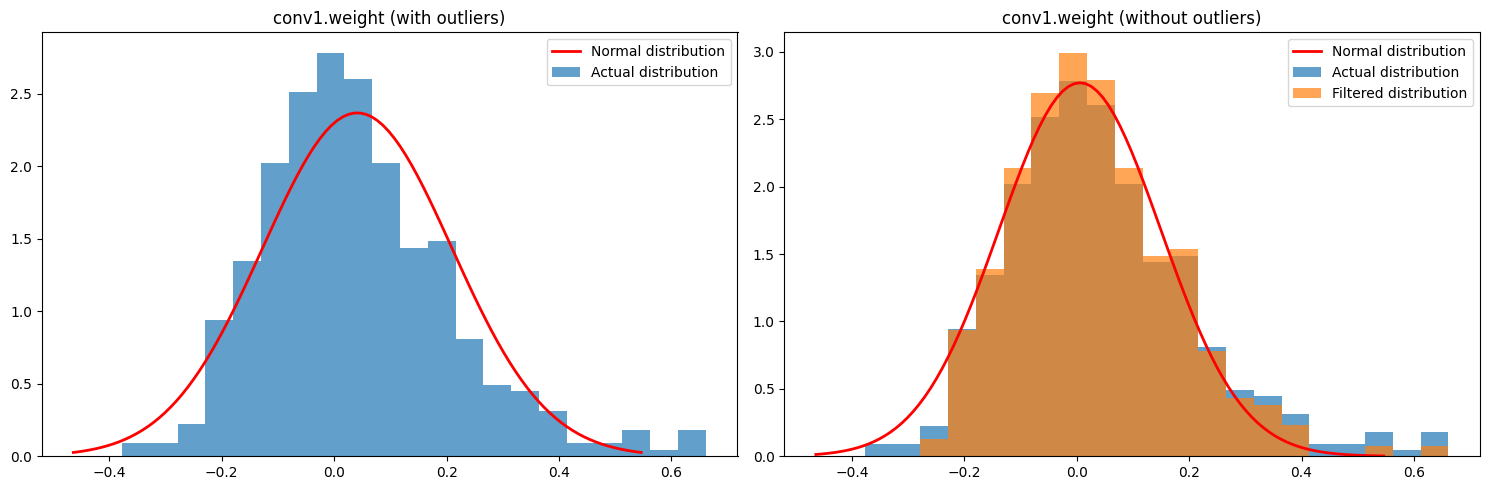

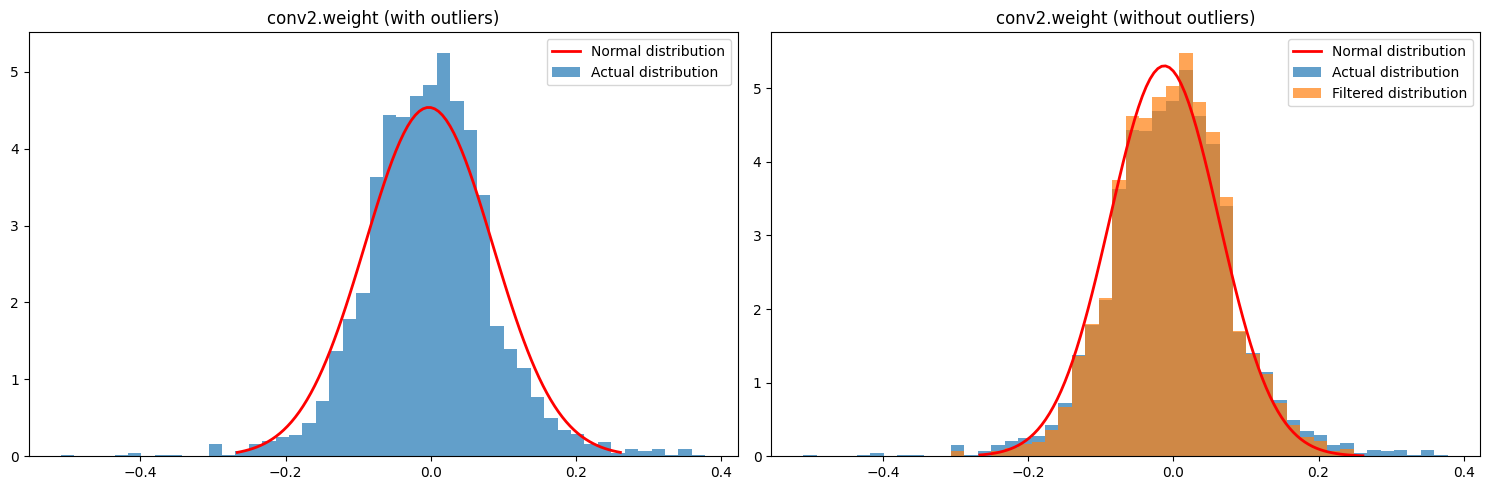

e:\MINI8\ITM\intro-to-ml\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


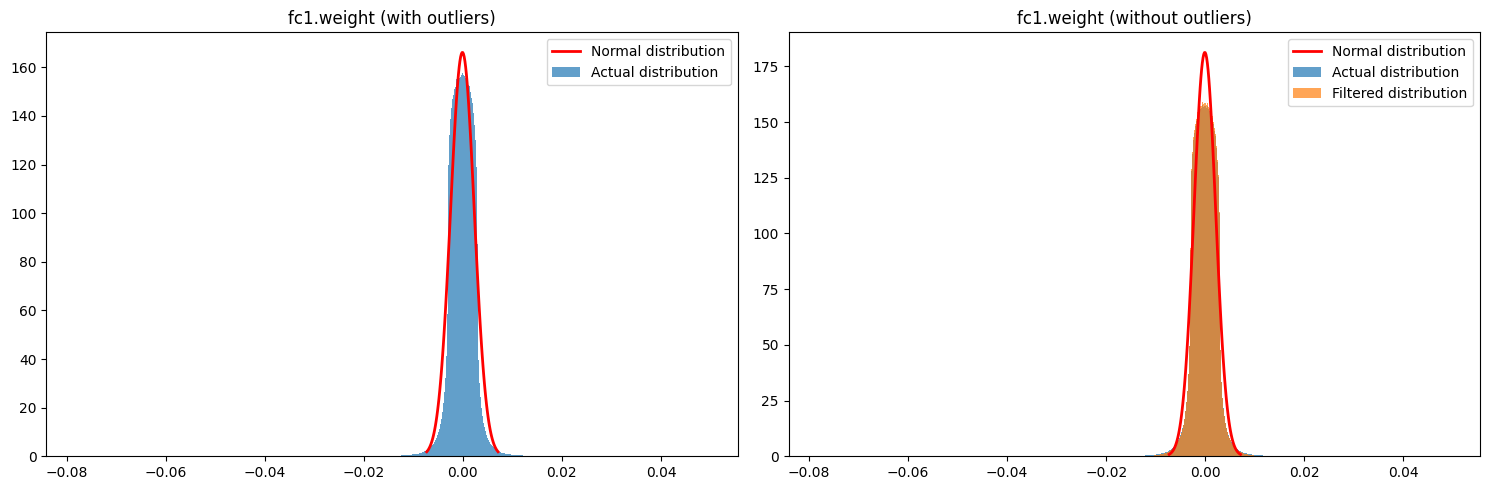

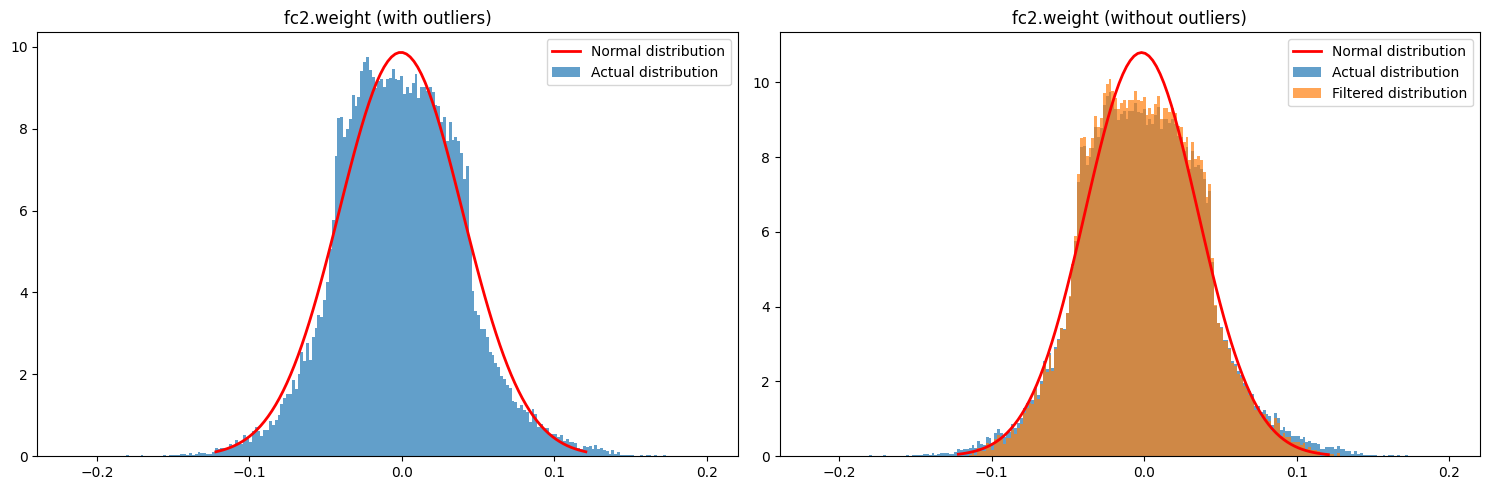

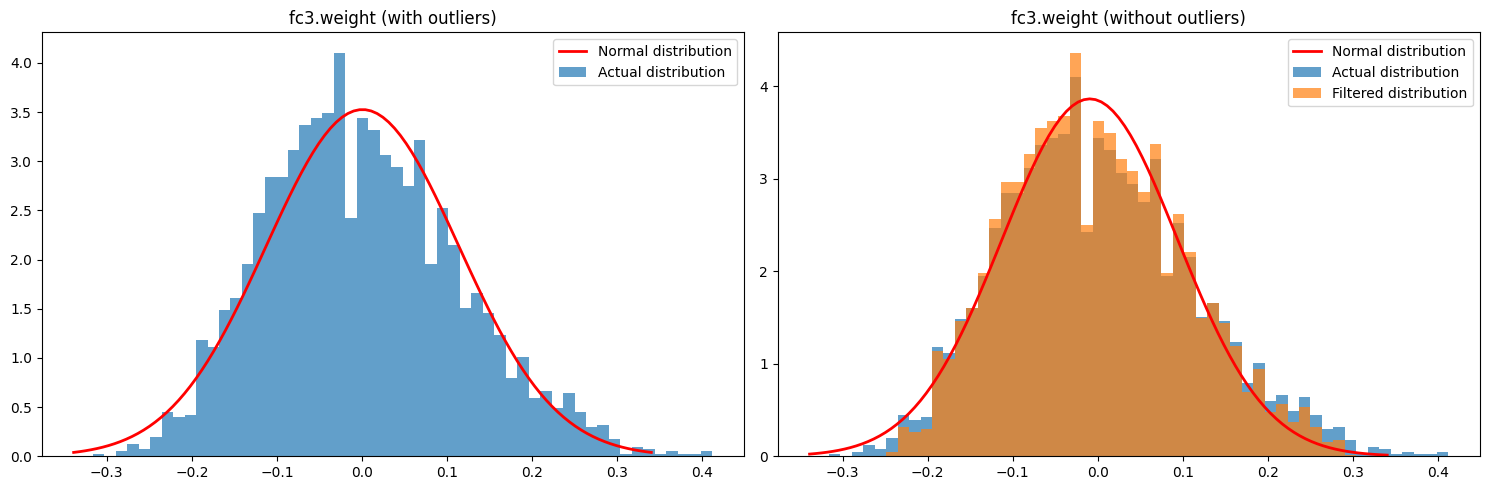

In [ ]:
final_dict = torch.load(f'{MODEL_PATH}/model_27090.pth', weights_only=True)

for layer in LAYERS:
    weights = final_dict[layer]
    weights = weights.cpu().numpy().flatten()
    mean = weights.mean().item()
    std = weights.std().item()
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    bins = int(sqrt(len(weights)))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax1 : plt.Axes = axes[0]
    ax2 : plt.Axes = axes[1]

    ax1.plot(x, 1/(std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2)), 
             linewidth=2, color='r', label='Normal distribution')
    ax1.hist(weights, bins=bins, density=True, alpha=0.7, label='Actual distribution')
    ax1.set_title(f'{layer} (with outliers)')
    ax1.legend()
    
    outlayers = weights[(weights < mean - 2*std) | (weights > mean + 2*std)]
    outlayers_mean = outlayers.mean().item()

    bin_counts, hist_edges = np.histogram(weights, bins=bins)
    outlayer_bin_count = [bin_counts[i] for i in range(bins) if mean - 2*std > hist_edges[i] or hist_edges[i] > mean + 2*std]
    mean_outlayer_bin_count = np.mean(outlayer_bin_count)
    bin_counts = bin_counts - mean_outlayer_bin_count
    bin_counts[bin_counts < 0] = 0
    filtered_mean = sum([hist_edges[i] * bin_counts[i] for i in range(bins)]) / bin_counts.sum()
    filtered_std = np.sqrt(np.sum([bin_counts[i] * (hist_edges[i] - filtered_mean)**2 for i in range(bins)]) / bin_counts.sum())
    
    ax2.plot(x, 1/(filtered_std * np.sqrt(2 * np.pi)) * np.exp(- (x - filtered_mean)**2 / (2 * filtered_std**2)), 
             linewidth=2, color='r', label='Normal distribution')
    ax2.hist(weights, bins=bins, density=True, alpha=0.7, label='Actual distribution')
    ax2.hist(hist_edges[:-1], bins=hist_edges, weights=bin_counts, alpha=0.7, label='Filtered distribution', density=True)
    ax2.set_title(f'{layer} (without outliers)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

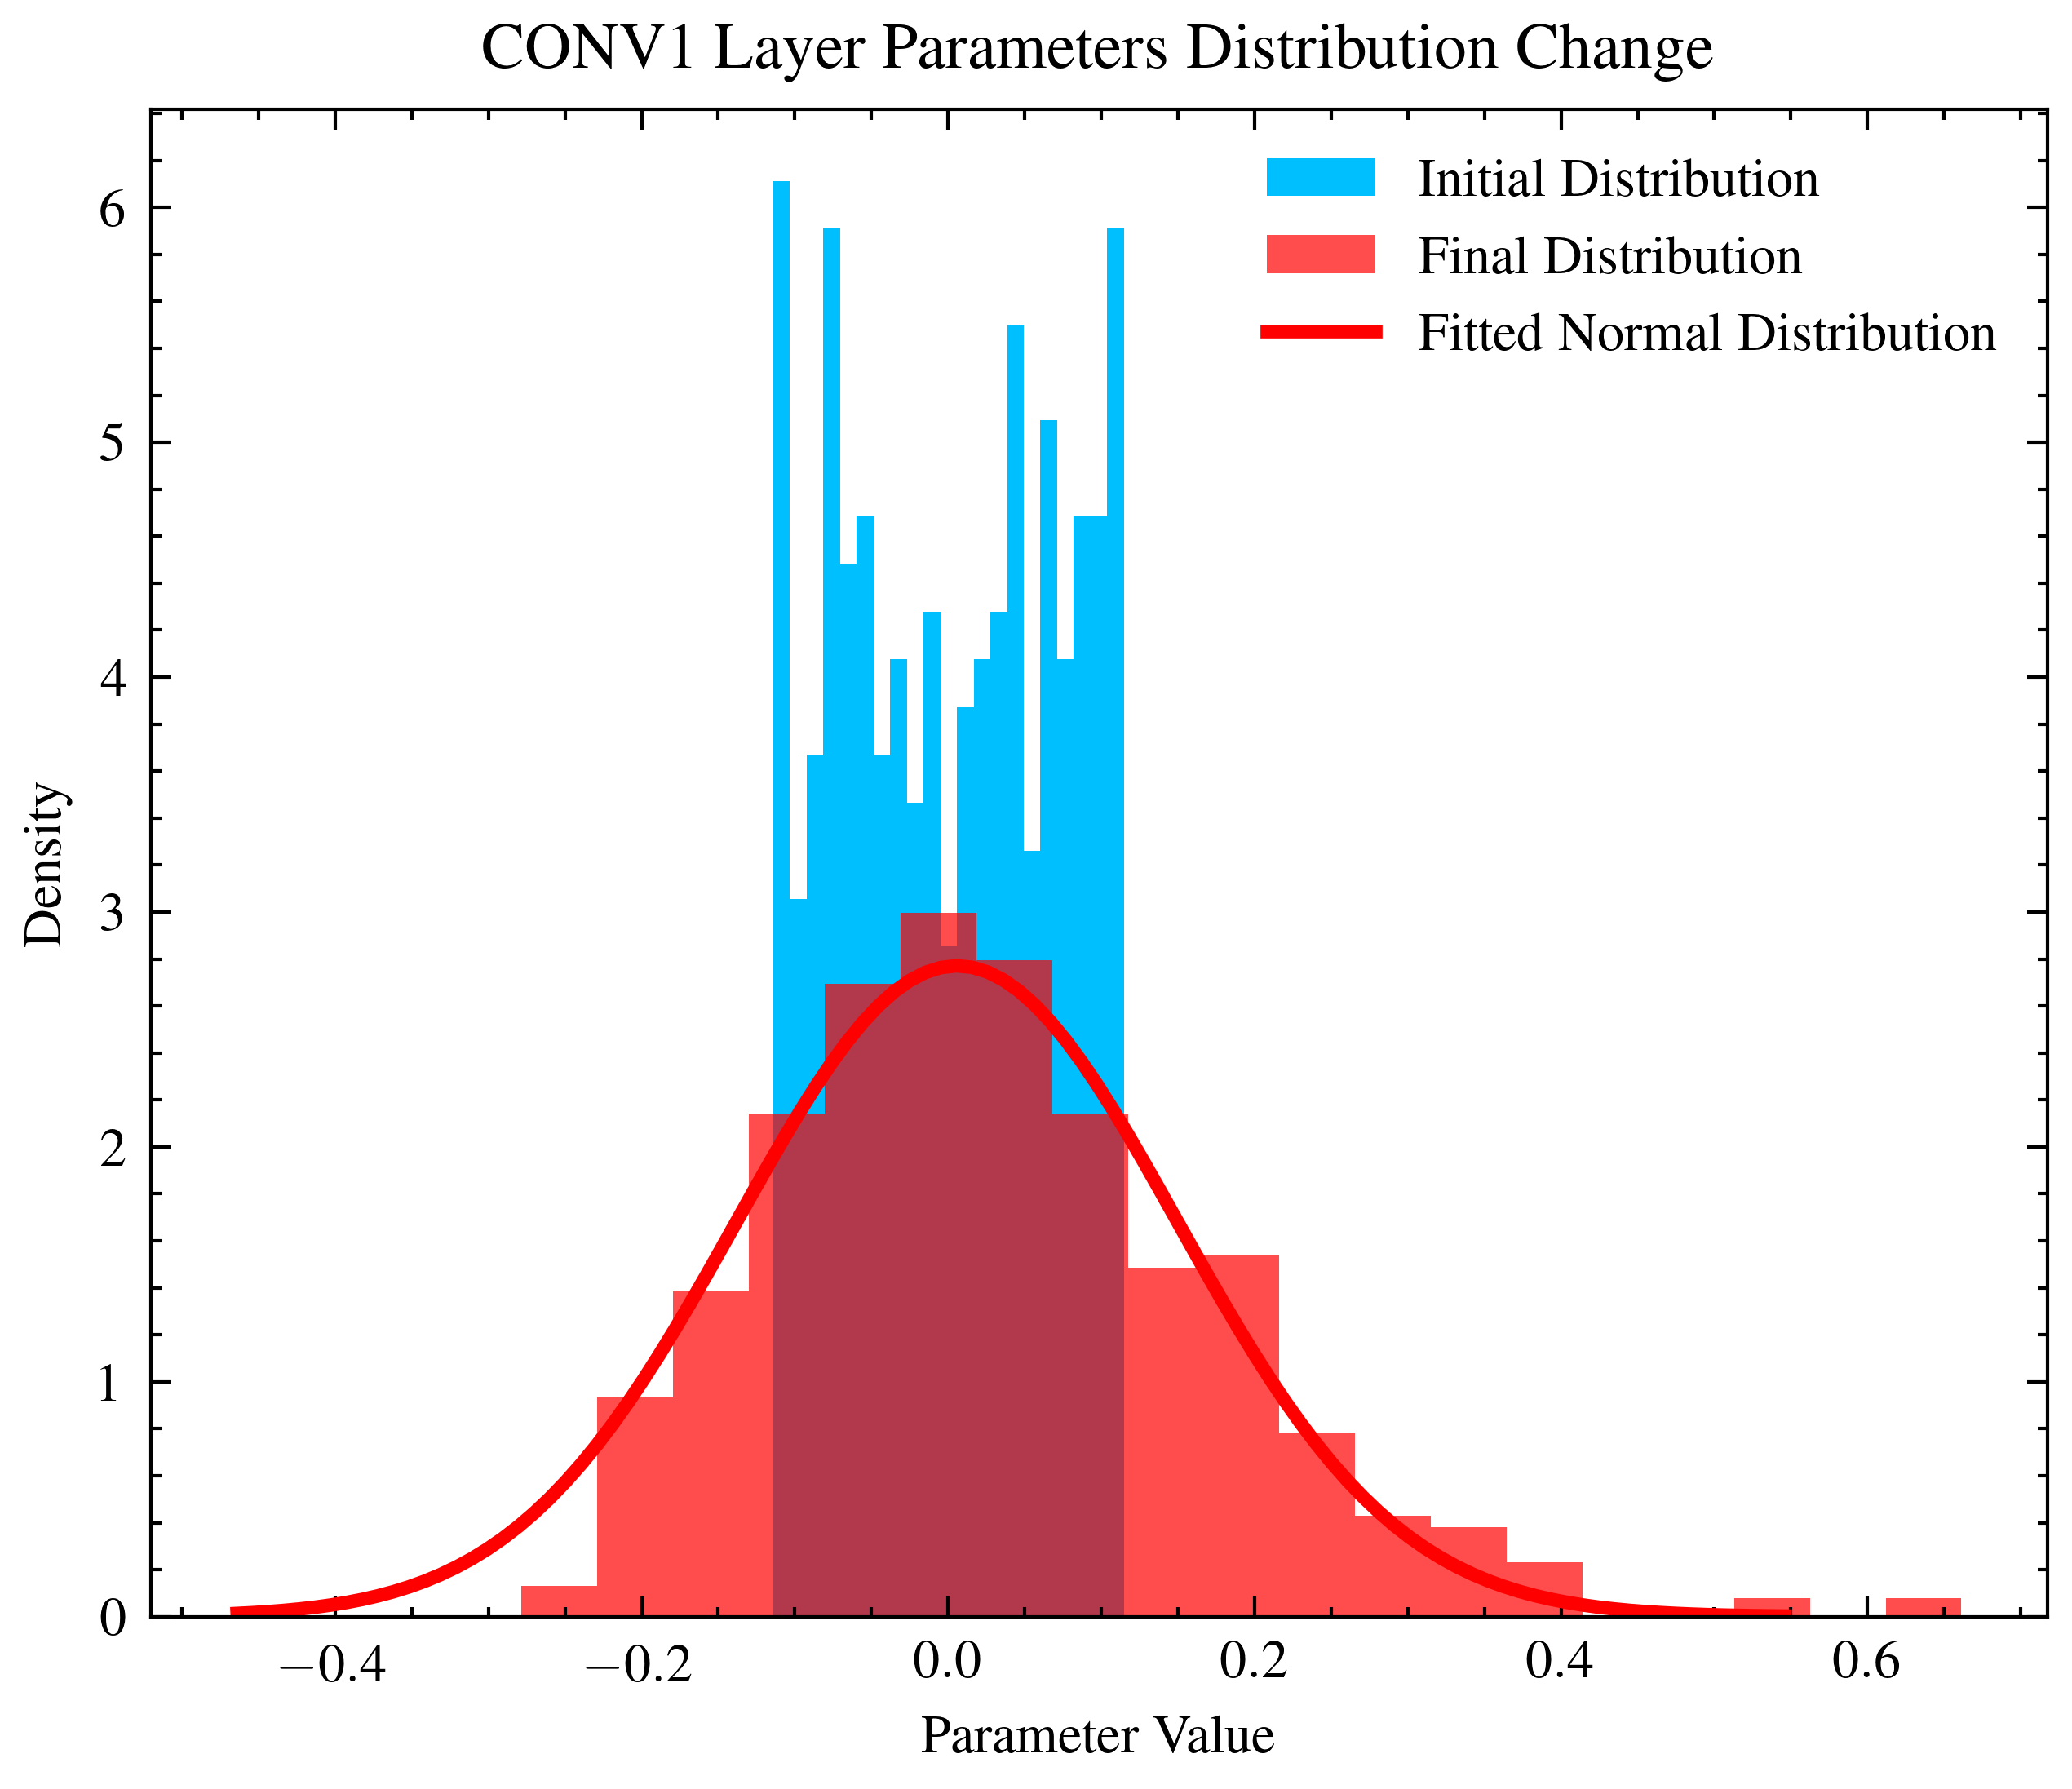

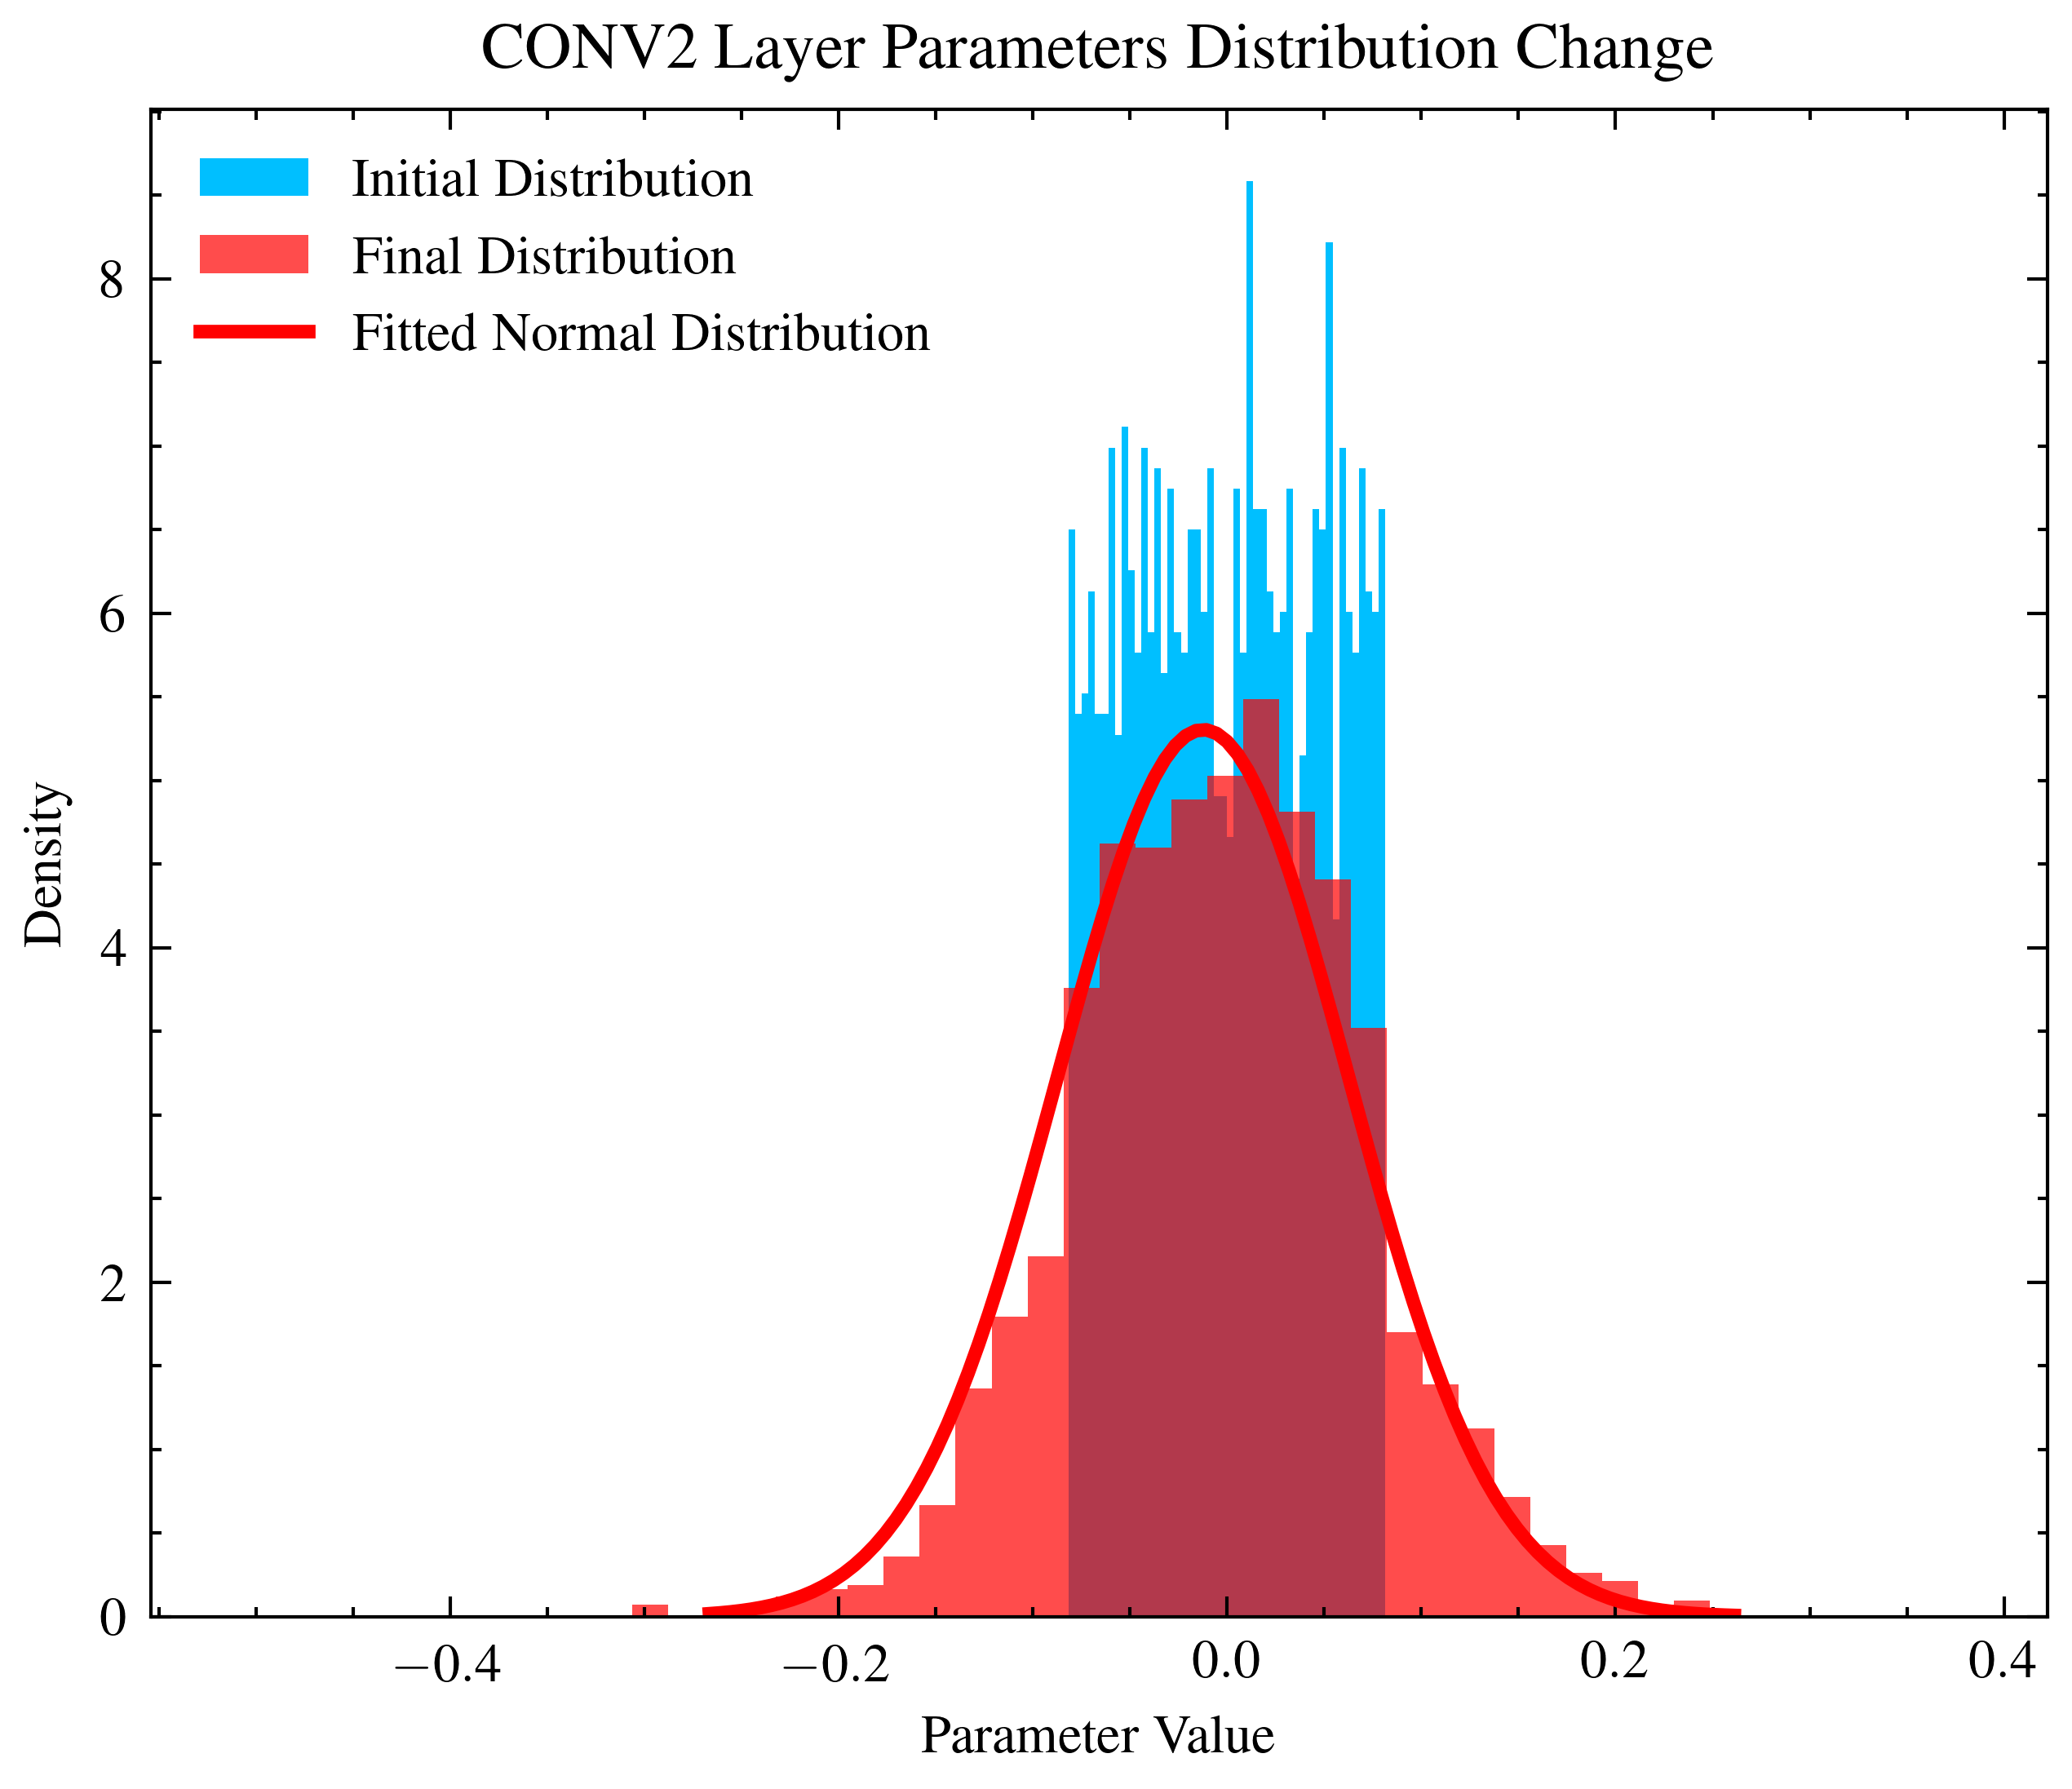

C:\Users\spawl\AppData\Local\Temp\ipykernel_11888\2847112957.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'charts/distribution_{layer}.png')
e:\MINI8\ITM\intro-to-ml\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


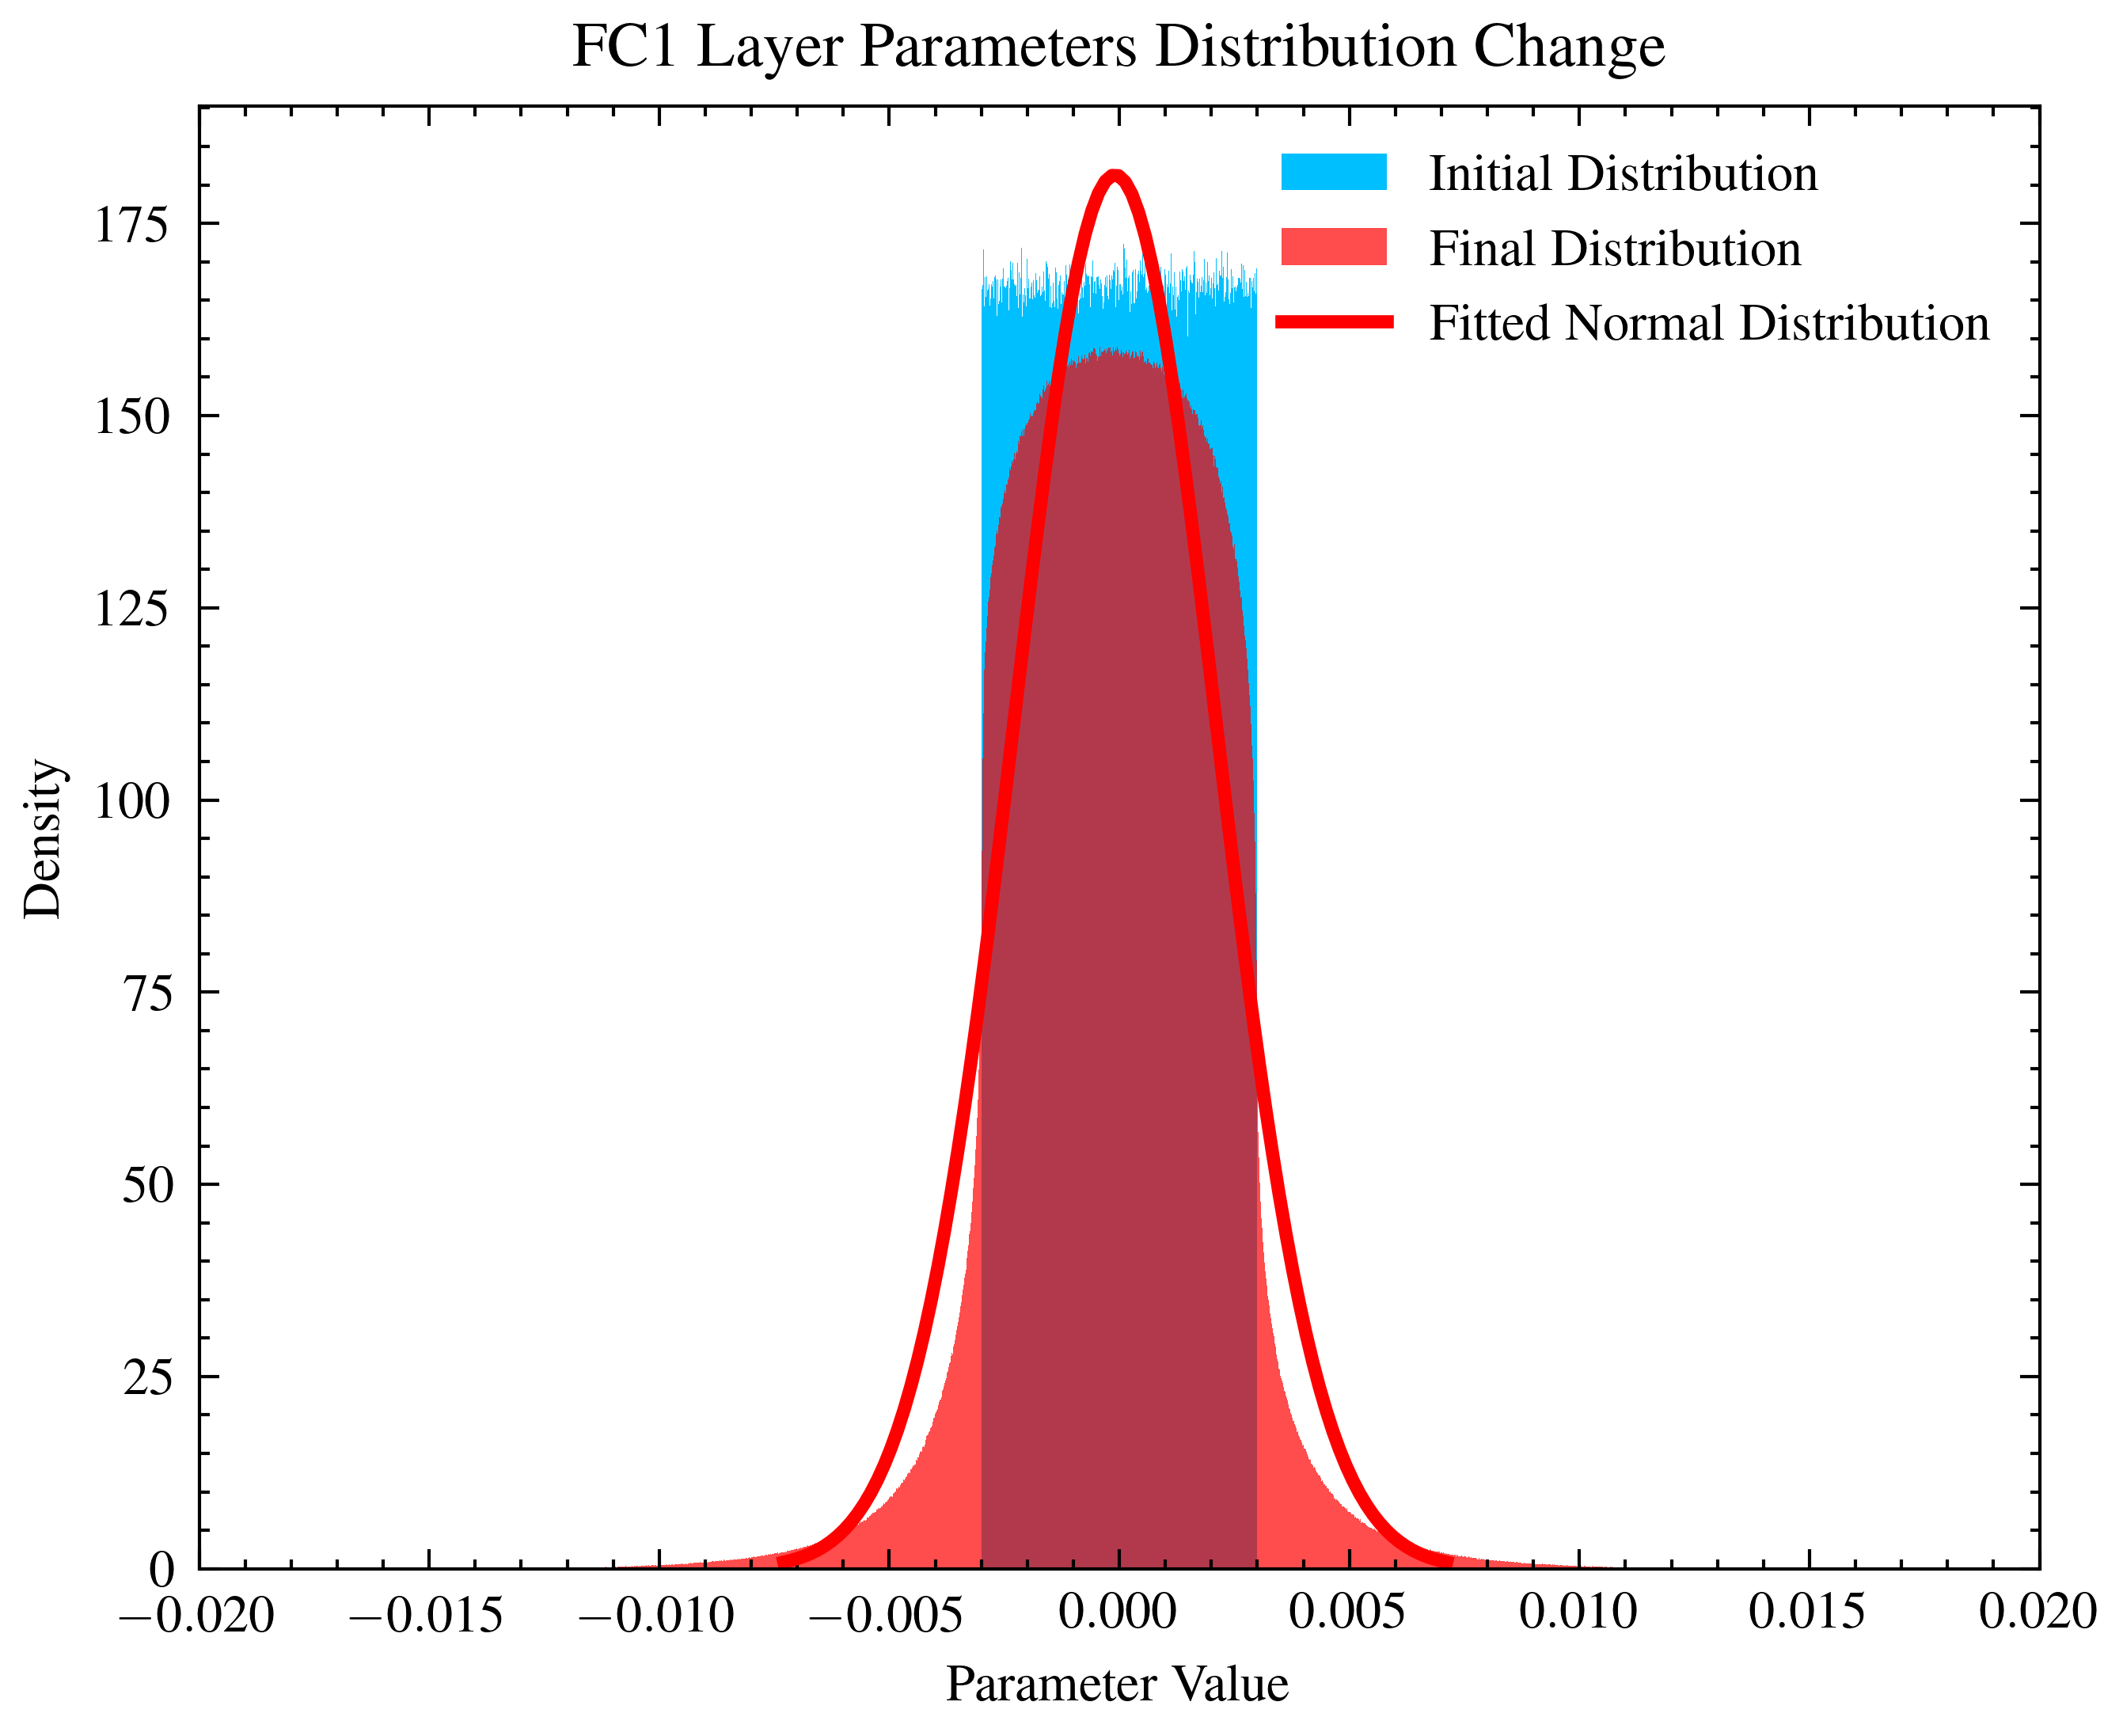

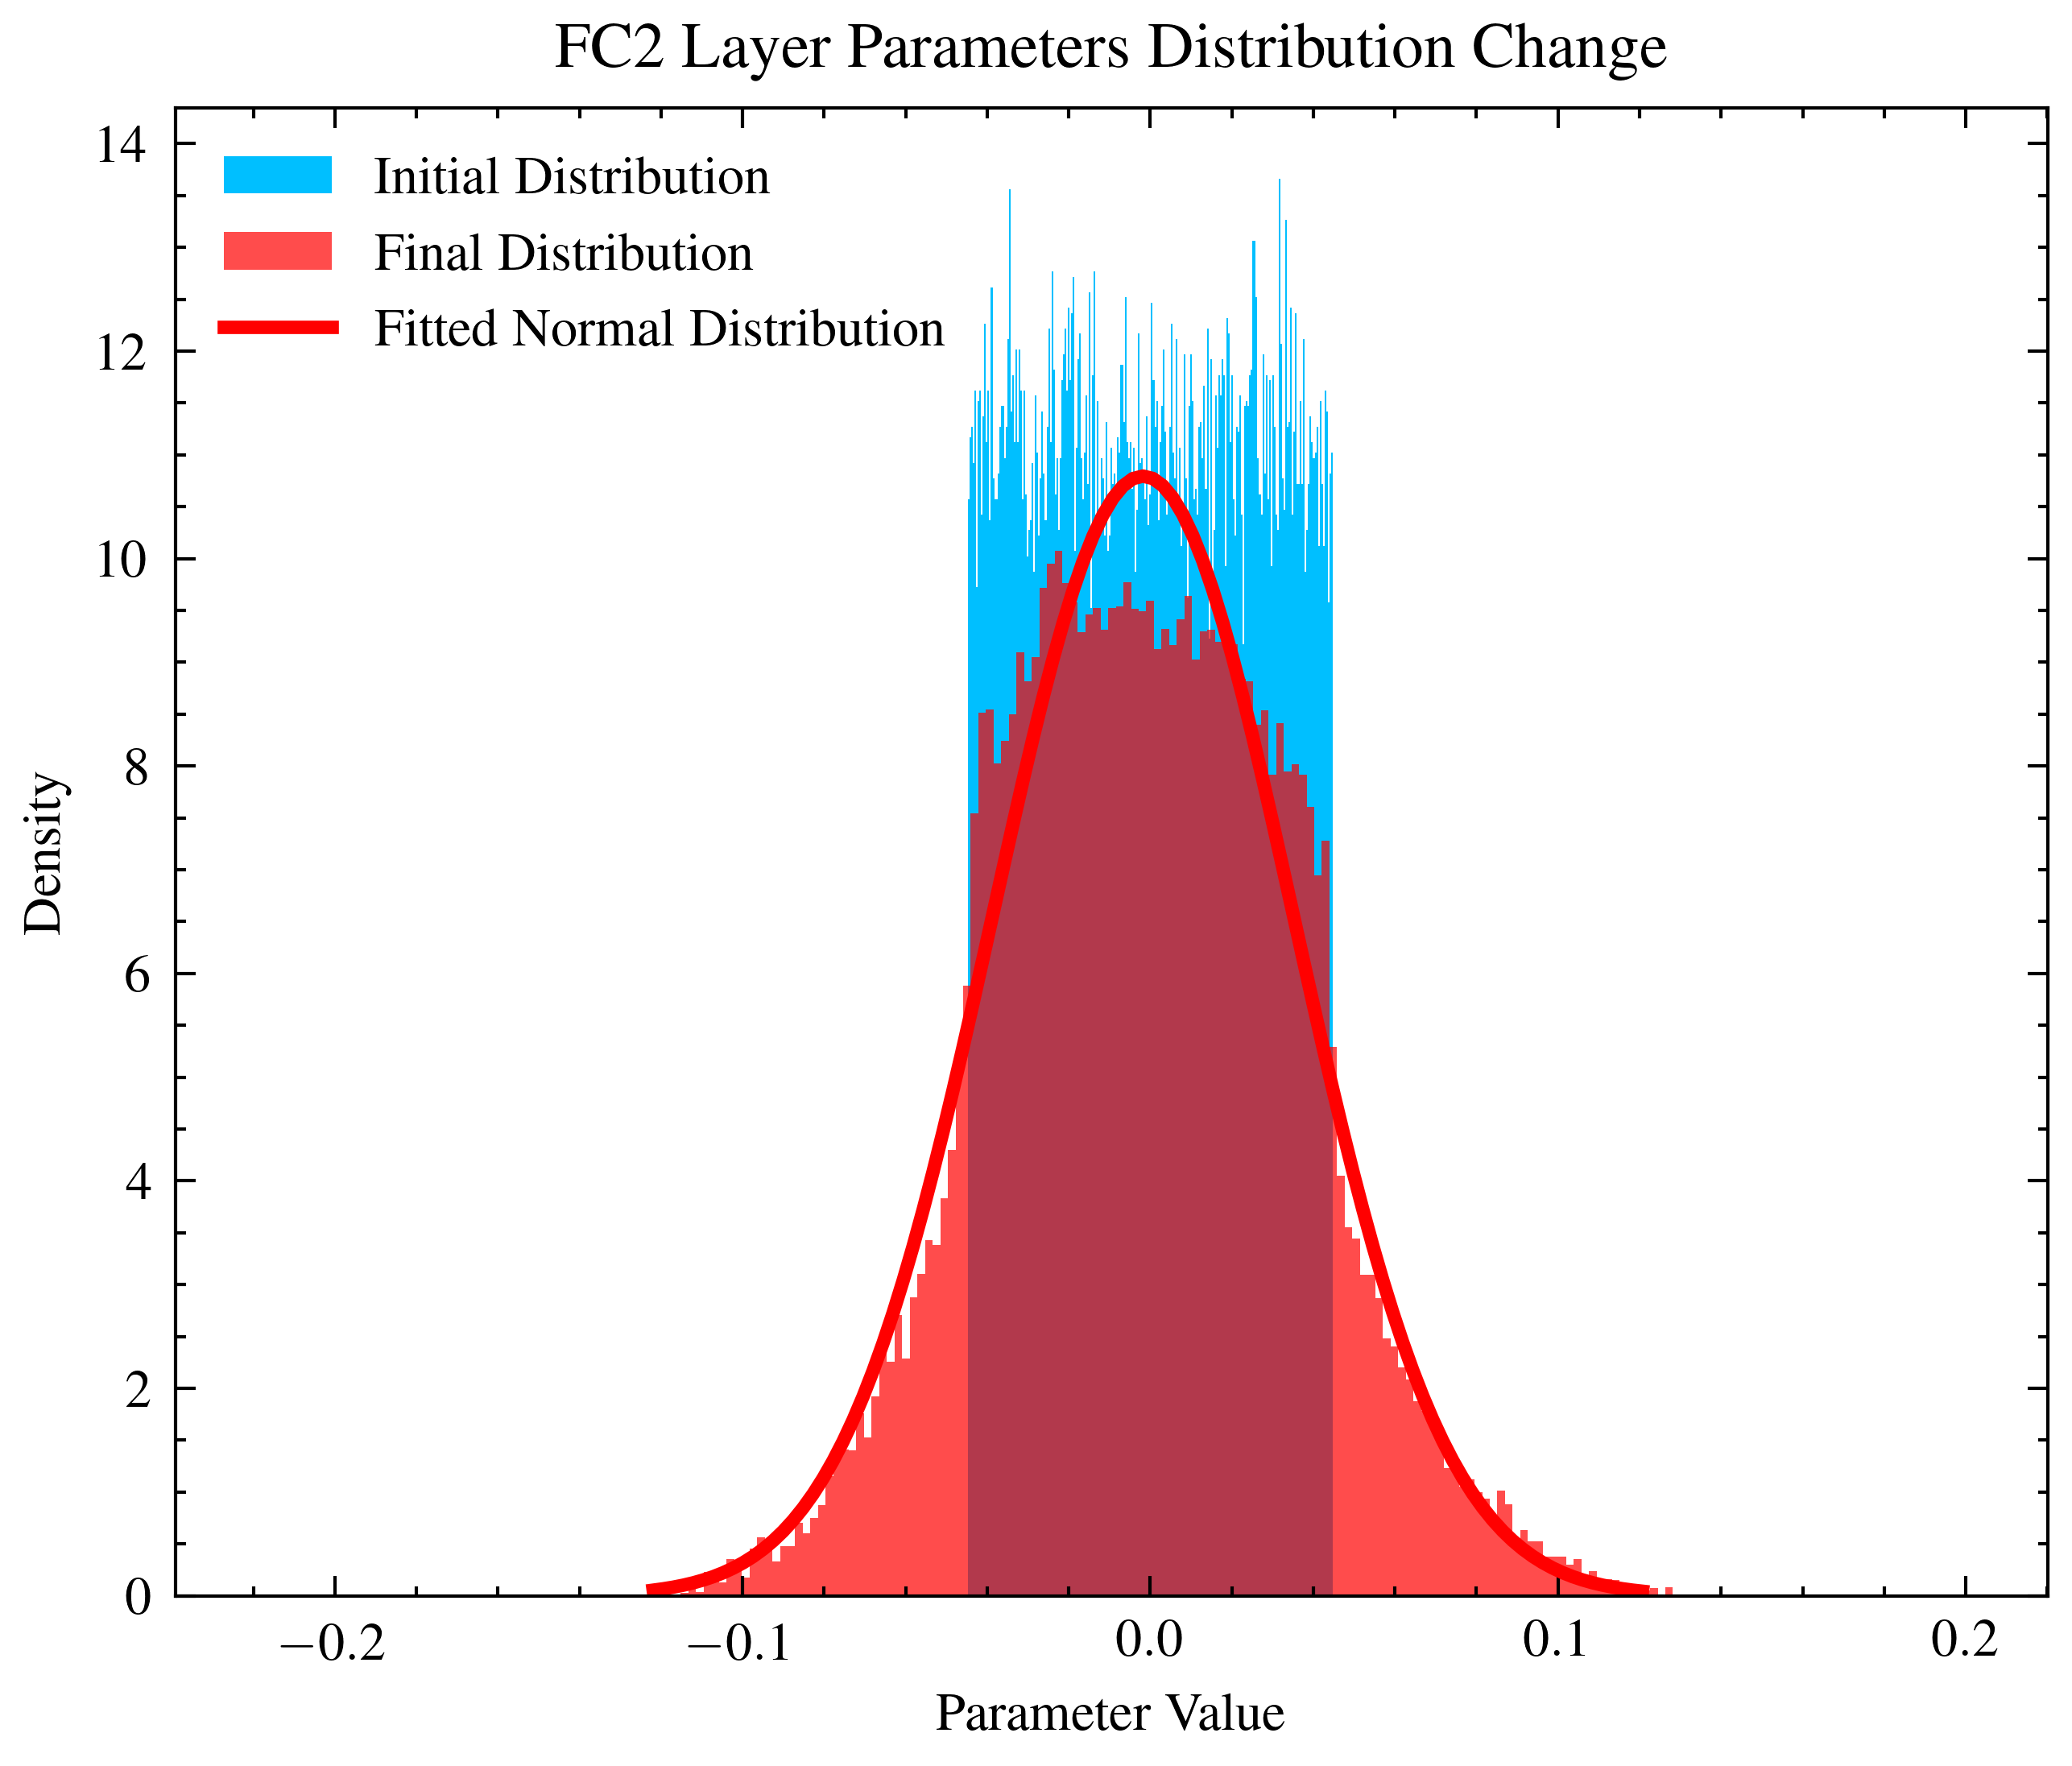

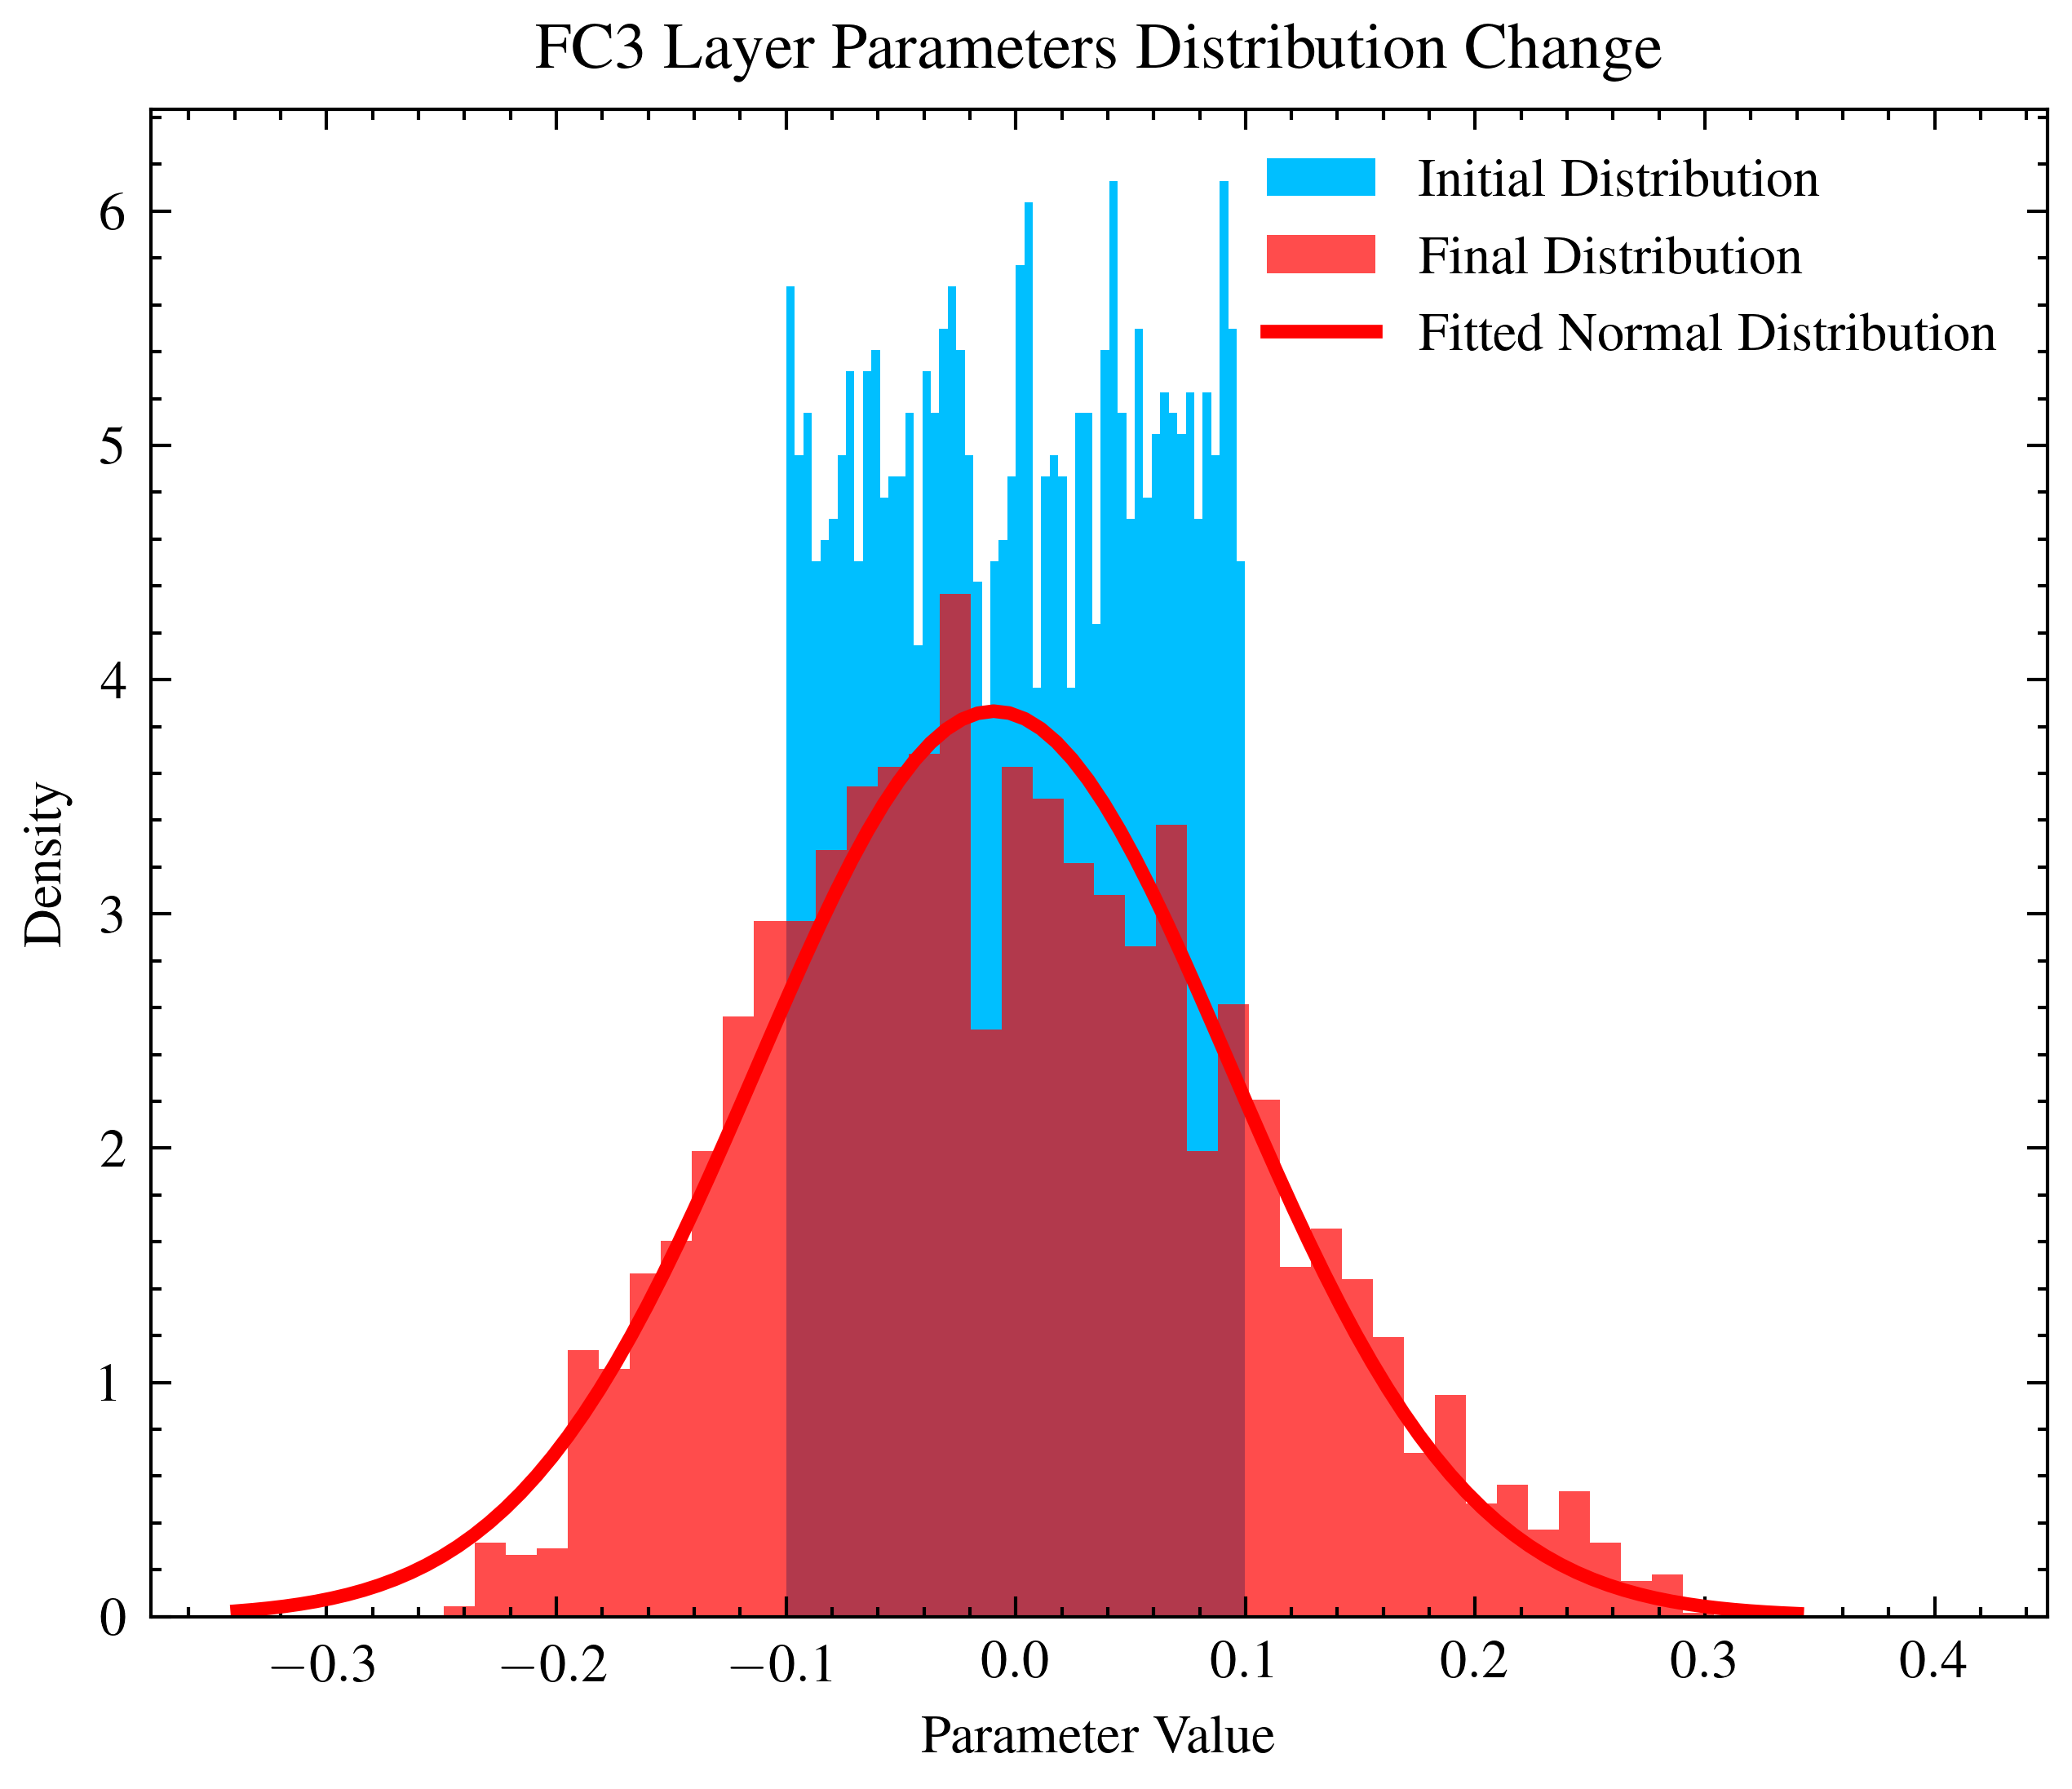

In [3]:
initial_dict = torch.load(f'{MODEL_PATH}/model_0.pth', weights_only=True)
final_dict = torch.load(f'{MODEL_PATH}/model_27090.pth', weights_only=True)

def plot_weights_histogram(layer, weights):
    mean = weights.mean().item()
    std = weights.std().item()
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    bins = int(sqrt(len(weights)))
    
    bin_counts, hist_edges = np.histogram(weights, bins=bins)
    outlayer_bin_count = [bin_counts[i] for i in range(bins) if mean - 2*std > hist_edges[i] or hist_edges[i] > mean + 2*std]
    mean_outlayer_bin_count = np.mean(outlayer_bin_count)
    bin_counts = bin_counts - mean_outlayer_bin_count
    bin_counts[bin_counts < 0] = 0
    filtered_mean = sum([hist_edges[i] * bin_counts[i] for i in range(bins)]) / bin_counts.sum()
    filtered_std = np.sqrt(np.sum([bin_counts[i] * (hist_edges[i] - filtered_mean)**2 for i in range(bins)]) / bin_counts.sum())
    
    plt.hist(hist_edges[:-1], bins=hist_edges, weights=bin_counts, alpha=0.7, label='Final Distribution', density=True, color='red')
    plt.plot(x, 1/(filtered_std * np.sqrt(2 * np.pi)) * np.exp(- (x - filtered_mean)**2 / (2 * filtered_std**2)), 
             linewidth=2, color='r', label='Fitted Normal Distribution')
    # plt.hist(weights, bins=bins, density=True, alpha=0.7, label='Actual distribution')
    plt.title(f'{layer} (without outliers)')
    plt.legend()

layer_to_lims = {
    'fc1.weight' : [-0.02, 0.02]
}

for layer in LAYERS:
    plt.figure(figsize=(5, 4))
    initial_weights = initial_dict[layer].cpu().numpy().flatten()
    final_weights = final_dict[layer].cpu().numpy().flatten()
    plt.hist(initial_weights, density=True, bins=int(sqrt(len(initial_weights))), label='Initial Distribution', color='black')
    plot_weights_histogram(layer, final_weights)

    if layer in layer_to_lims:
        plt.xlim(layer_to_lims[layer])
    
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    plt.title(f"{layer_to_view_name[layer]} Layer Parameters Distribution Change")
    plt.savefig(f'charts/distribution_{layer}.png')
    plt.show()

In [7]:
initial_dict = torch.load(f'{MODEL_PATH}/model_0.pth', weights_only=True)
final_dict = torch.load(f'{MODEL_PATH}/model_27090.pth', weights_only=True)


for layer in LAYERS: 
    initial_weights = initial_dict[layer].cpu().numpy().flatten()
    final_weights = final_dict[layer].cpu().numpy().flatten()

    weight_total_change = np.abs(final_weights / initial_weights - 1)
    print(f'{layer} big changes: {weight_total_change.mean()}')

conv1.weight big changes: 4.4446516036987305
conv2.weight big changes: 2.560537815093994
fc1.weight big changes: 4.11458683013916
fc2.weight big changes: 5.9555463790893555
fc3.weight big changes: 13.099395751953125


## Changes in individual layers

100%|██████████| 56/56 [00:19<00:00,  2.91it/s]


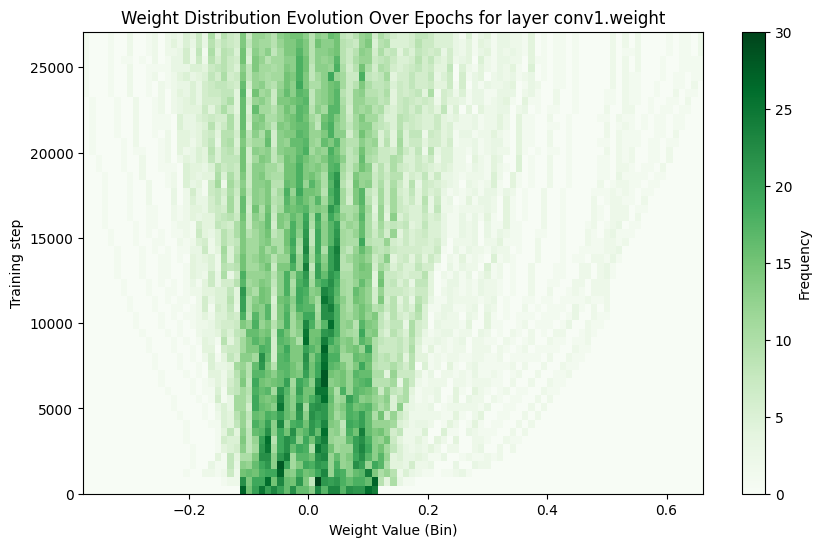

100%|██████████| 56/56 [00:19<00:00,  2.90it/s]


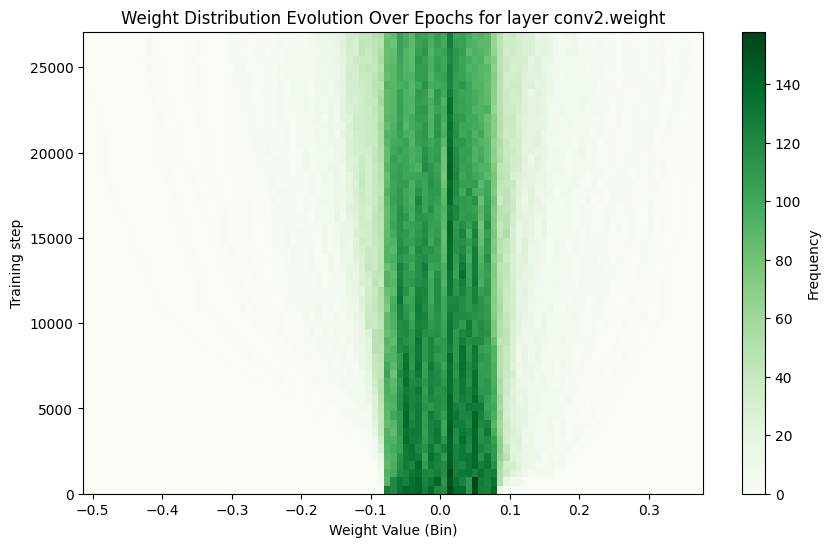

100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


In [13]:
def plot_weight_distribution(layer: str):
    weights = []
    total_steps = 0

    for file in tqdm(glob.glob(f'{MODEL_PATH}/*.pth')):
        model_file_name = Path(file).name
        steps = int(model_file_name.split('_')[1].split('.')[0])
        total_steps = max(steps, total_steps)
        state_dict = torch.load(file, weights_only=True)
    
        layer_weights = state_dict[layer].flatten().cpu().numpy()
        weights.append((steps, layer_weights))

    weights = sorted(weights)
    _, weights = zip(*weights)

    w_min = min([w.min() for w in weights])
    w_max = max([w.max() for w in weights])
    bins = np.linspace(w_min, w_max, 100)
    heatmap_data = []

    for w in weights:
        counts, _ = np.histogram(w, bins=bins)
        heatmap_data.append(counts)

    heatmap_data = np.array(heatmap_data)

    plt.figure(figsize=(10, 6))
    plt.imshow(heatmap_data, aspect='auto', cmap='Greens', origin='lower',
           extent=[bins[0], bins[-1], 0, total_steps])
    plt.colorbar(label='Frequency')
    plt.xlabel('Weight Value (Bin)')
    plt.ylabel('Training step')
    plt.title(f'Weight Distribution Evolution Over Epochs for layer {layer}')
    plt.show()

for layer in ['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight']:
    plot_weight_distribution(layer)


## Layer robustness

In [5]:
ARCHITRECTURE = SimpleConvolutionArchitecture()
CLASS_LABELS = os.listdir('../data/tsrc_spectrograms_cleaned/train')

In [6]:
DATASET_NAME = "tsrc_spectrograms_cleaned_augmented_sharpened"
DATASET_PATH = f"../data/{DATASET_NAME}"
FOLDER_PATH = f"../models/robustness_3_single_cnn_{DATASET_NAME}"
model = CNNClassifier(FOLDER_PATH, architecture=ARCHITRECTURE)

In [7]:
hist_edges, roustness_results = model.fit(
    f"{DATASET_PATH}/train", 
    f"{DATASET_PATH}/validation",
    batch_size=32,
    n_epochs=6,
    measure_layer_robusness_step=500,
)

Running training on GPU...


p:\MINI8\I2ML\intro-to-ml\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:  11%|█         | 499/4515 [00:39<02:28, 27.02it/s] 

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.66it/s]


Saving weights...


Training:  22%|██▏       | 998/4515 [05:17<02:11, 26.73it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.80it/s]


Saving weights...


Training:  33%|███▎      | 1498/4515 [09:33<01:51, 27.14it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.50it/s]


Saving weights...


Training:  44%|████▍     | 1998/4515 [13:49<01:33, 26.92it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.48it/s]


Saving weights...


Training:  55%|█████▌    | 2498/4515 [18:04<01:15, 26.84it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.55it/s]


Saving weights...


Training:  66%|██████▋   | 2998/4515 [22:20<00:55, 27.12it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.46it/s]


Saving weights...


Training:  77%|███████▋  | 3498/4515 [26:37<00:37, 26.86it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.69it/s]


Saving weights...


Training:  89%|████████▊ | 3998/4515 [30:52<00:19, 26.77it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.83it/s]


Saving weights...


Training: 100%|█████████▉| 4498/4515 [35:09<00:00, 26.96it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.75it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 46.64it/s]


Epoch 0 Done after 2368.406093597412 seconds


Training:  11%|█         | 484/4515 [00:17<02:27, 27.40it/s]

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.72it/s]


Saving weights...


Training:  22%|██▏       | 983/4515 [04:32<02:09, 27.37it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.81it/s]


Saving weights...


Training:  33%|███▎      | 1483/4515 [08:47<01:51, 27.31it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.65it/s]


Saving weights...


Training:  44%|████▍     | 1983/4515 [13:03<01:32, 27.25it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.76it/s]


Saving weights...


Training:  55%|█████▍    | 2483/4515 [17:19<01:14, 27.17it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.42it/s]


Saving weights...


Training:  66%|██████▌   | 2983/4515 [21:34<00:56, 27.25it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.55it/s]


Saving weights...


Training:  77%|███████▋  | 3483/4515 [25:50<00:38, 27.13it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.44it/s]


Saving weights...


Training:  88%|████████▊ | 3983/4515 [30:07<00:19, 27.09it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.49it/s]


Saving weights...


Training:  99%|█████████▉| 4483/4515 [34:24<00:01, 26.85it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.47it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 46.66it/s]


Epoch 1 Done after 2325.3656113147736 seconds


Training:  10%|█         | 469/4515 [00:17<02:28, 27.33it/s]

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.41it/s]


Saving weights...


Training:  21%|██▏       | 968/4515 [04:34<02:09, 27.38it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.50it/s]


Saving weights...


Training:  33%|███▎      | 1468/4515 [08:50<01:51, 27.23it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.61it/s]


Saving weights...


Training:  44%|████▎     | 1968/4515 [13:07<01:33, 27.27it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.69it/s]


Saving weights...


Training:  55%|█████▍    | 2468/4515 [17:23<01:15, 27.01it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.50it/s]


Saving weights...


Training:  66%|██████▌   | 2968/4515 [21:39<00:56, 27.16it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.66it/s]


Saving weights...


Training:  77%|███████▋  | 3468/4515 [25:55<00:38, 27.02it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.37it/s]


Saving weights...


Training:  88%|████████▊ | 3968/4515 [30:12<00:20, 26.82it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.46it/s]


Saving weights...


Training:  99%|█████████▉| 4468/4515 [34:30<00:01, 26.42it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.33it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 46.73it/s]


Epoch 2 Done after 2331.8934674263 seconds


Training:  10%|█         | 454/4515 [00:16<02:28, 27.40it/s]

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.27it/s]


Saving weights...


Training:  21%|██        | 953/4515 [04:33<02:10, 27.35it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.06it/s]


Saving weights...


Training:  32%|███▏      | 1453/4515 [08:52<01:52, 27.15it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.87it/s]


Saving weights...


Training:  43%|████▎     | 1953/4515 [13:11<01:34, 27.01it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.07it/s]


Saving weights...


Training:  54%|█████▍    | 2453/4515 [17:30<01:16, 26.94it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.38it/s]


Saving weights...


Training:  65%|██████▌   | 2953/4515 [21:50<00:57, 27.16it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.52it/s]


Saving weights...


Training:  76%|███████▋  | 3453/4515 [26:10<00:39, 26.85it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.01it/s]


Saving weights...


Training:  88%|████████▊ | 3953/4515 [30:30<00:20, 26.81it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.83it/s]


Saving weights...


Training:  99%|█████████▊| 4453/4515 [34:49<00:02, 26.27it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.82it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 45.85it/s]


Epoch 3 Done after 2355.893105983734 seconds


Training:  10%|▉         | 439/4515 [00:16<02:29, 27.29it/s]

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.62it/s]


Saving weights...


Training:  21%|██        | 938/4515 [04:36<02:11, 27.10it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.39it/s]


Saving weights...


Training:  32%|███▏      | 1438/4515 [08:57<01:56, 26.39it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.74it/s]


Saving weights...


Training:  43%|████▎     | 1938/4515 [13:17<01:35, 27.04it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.36it/s]


Saving weights...


Training:  54%|█████▍    | 2438/4515 [17:38<01:17, 26.95it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.69it/s]


Saving weights...


Training:  65%|██████▌   | 2938/4515 [21:59<00:58, 27.05it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.68it/s]


Saving weights...


Training:  76%|███████▌  | 3438/4515 [26:20<00:40, 26.88it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 44.68it/s]


Saving weights...


Training:  87%|████████▋ | 3938/4515 [30:42<00:21, 26.83it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.48it/s]


Saving weights...


Training:  98%|█████████▊| 4438/4515 [35:03<00:02, 26.21it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.65it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 45.88it/s]


Epoch 4 Done after 2371.7493755817413 seconds


Training:   9%|▉         | 424/4515 [00:15<02:30, 27.21it/s]

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.36it/s]


Saving weights...


Training:  20%|██        | 923/4515 [04:37<02:13, 26.87it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.47it/s]


Saving weights...


Training:  32%|███▏      | 1423/4515 [09:22<02:21, 21.88it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.41it/s]


Saving weights...


Training:  43%|████▎     | 1923/4515 [13:46<01:59, 21.78it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.62it/s]


Saving weights...


Training:  54%|█████▎    | 2423/4515 [18:10<01:30, 22.99it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 46.09it/s]


Saving weights...


Training:  65%|██████▍   | 2923/4515 [22:35<01:16, 20.78it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.61it/s]


Saving weights...


Training:  76%|███████▌  | 3423/4515 [26:58<00:49, 21.93it/s]   

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.94it/s]


Saving weights...


Training:  87%|████████▋ | 3923/4515 [31:22<00:25, 22.82it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:22<00:00, 45.33it/s]


Saving weights...


Training:  98%|█████████▊| 4423/4515 [35:46<00:04, 21.83it/s]  

Measuring layer robustness...


Evaluating: 100%|██████████| 1001/1001 [00:21<00:00, 45.59it/s]


Saving weights...


Validation: 100%|██████████| 1001/1001 [00:21<00:00, 45.82it/s]


Epoch 5 Done after 2414.976970434189 seconds
Finished Training


In [8]:
df = pd.DataFrame(roustness_results)
df.to_csv(f"{FOLDER_PATH}/robustness_results.csv", index=False)

In [7]:
df = pd.read_csv(f"{FOLDER_PATH}/robustness_results.csv")
df.head()

step  epoch         layer  base_accuracy  init_accuracy  random_accuracy
0   500      0  conv1.weight       0.185518       0.179677         0.173617
1   500      0  conv2.weight       0.185518       0.185800         0.157311
2   500      0    fc1.weight       0.185518       0.034267         0.037735
3   500      0    fc2.weight       0.185518       0.200231         0.021741
4   500      0    fc3.weight       0.185518       0.152407         0.033705

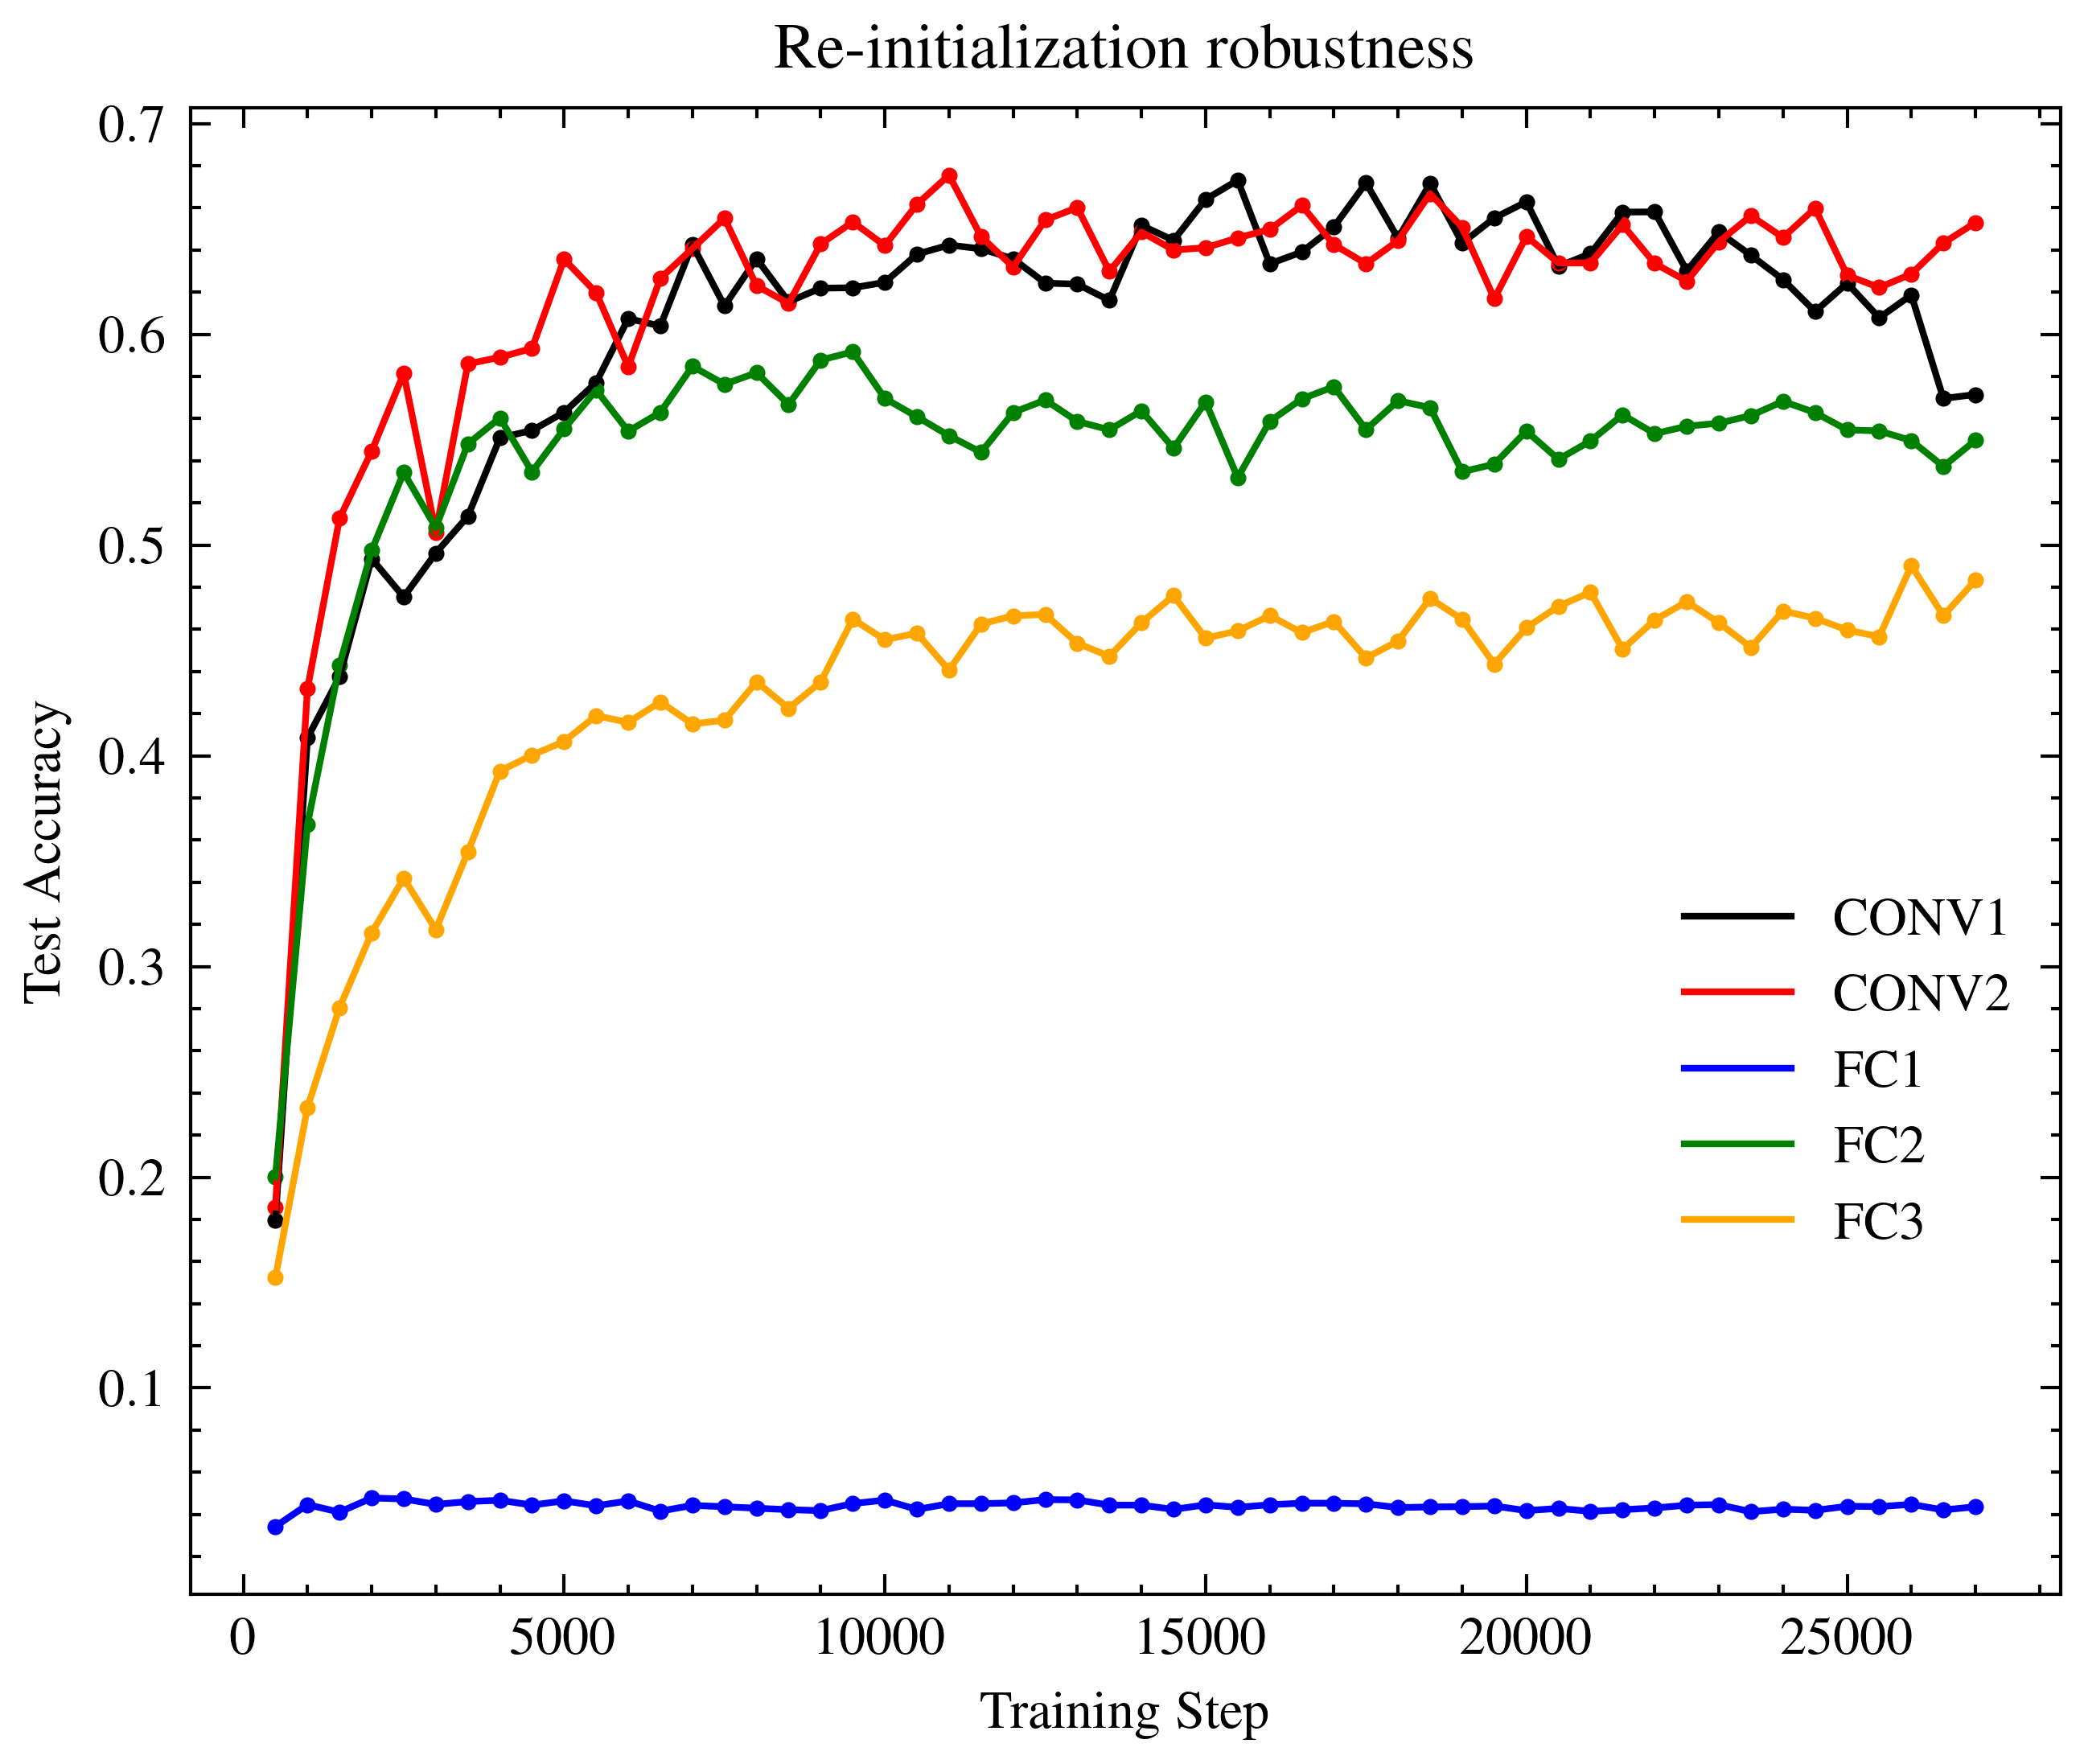

In [23]:
plt.figure(figsize=(5, 4))

for layer in LAYERS:
	df_layer = df[df['layer'] == layer]
	plt.plot(df_layer['step'], df_layer['init_accuracy'], label=layer_to_view_name[layer], color=layer_to_color[layer], linestyle='-')
	plt.scatter(df_layer['step'], df_layer['init_accuracy'], s=2, color=layer_to_color[layer])

plt.title('Re-initialization robustness')
plt.xlabel('Training Step')
plt.ylabel('Test Accuracy')
plt.legend(loc="center right", bbox_to_anchor=(1, 0.35))
plt.savefig('charts/re-initializaton-robustness.png')
plt.show()

C:\Users\spawl\AppData\Local\Temp\ipykernel_11888\2036760858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_layer['random_accuracy'] = df_layer['random_accuracy'].rolling(window=10).mean()


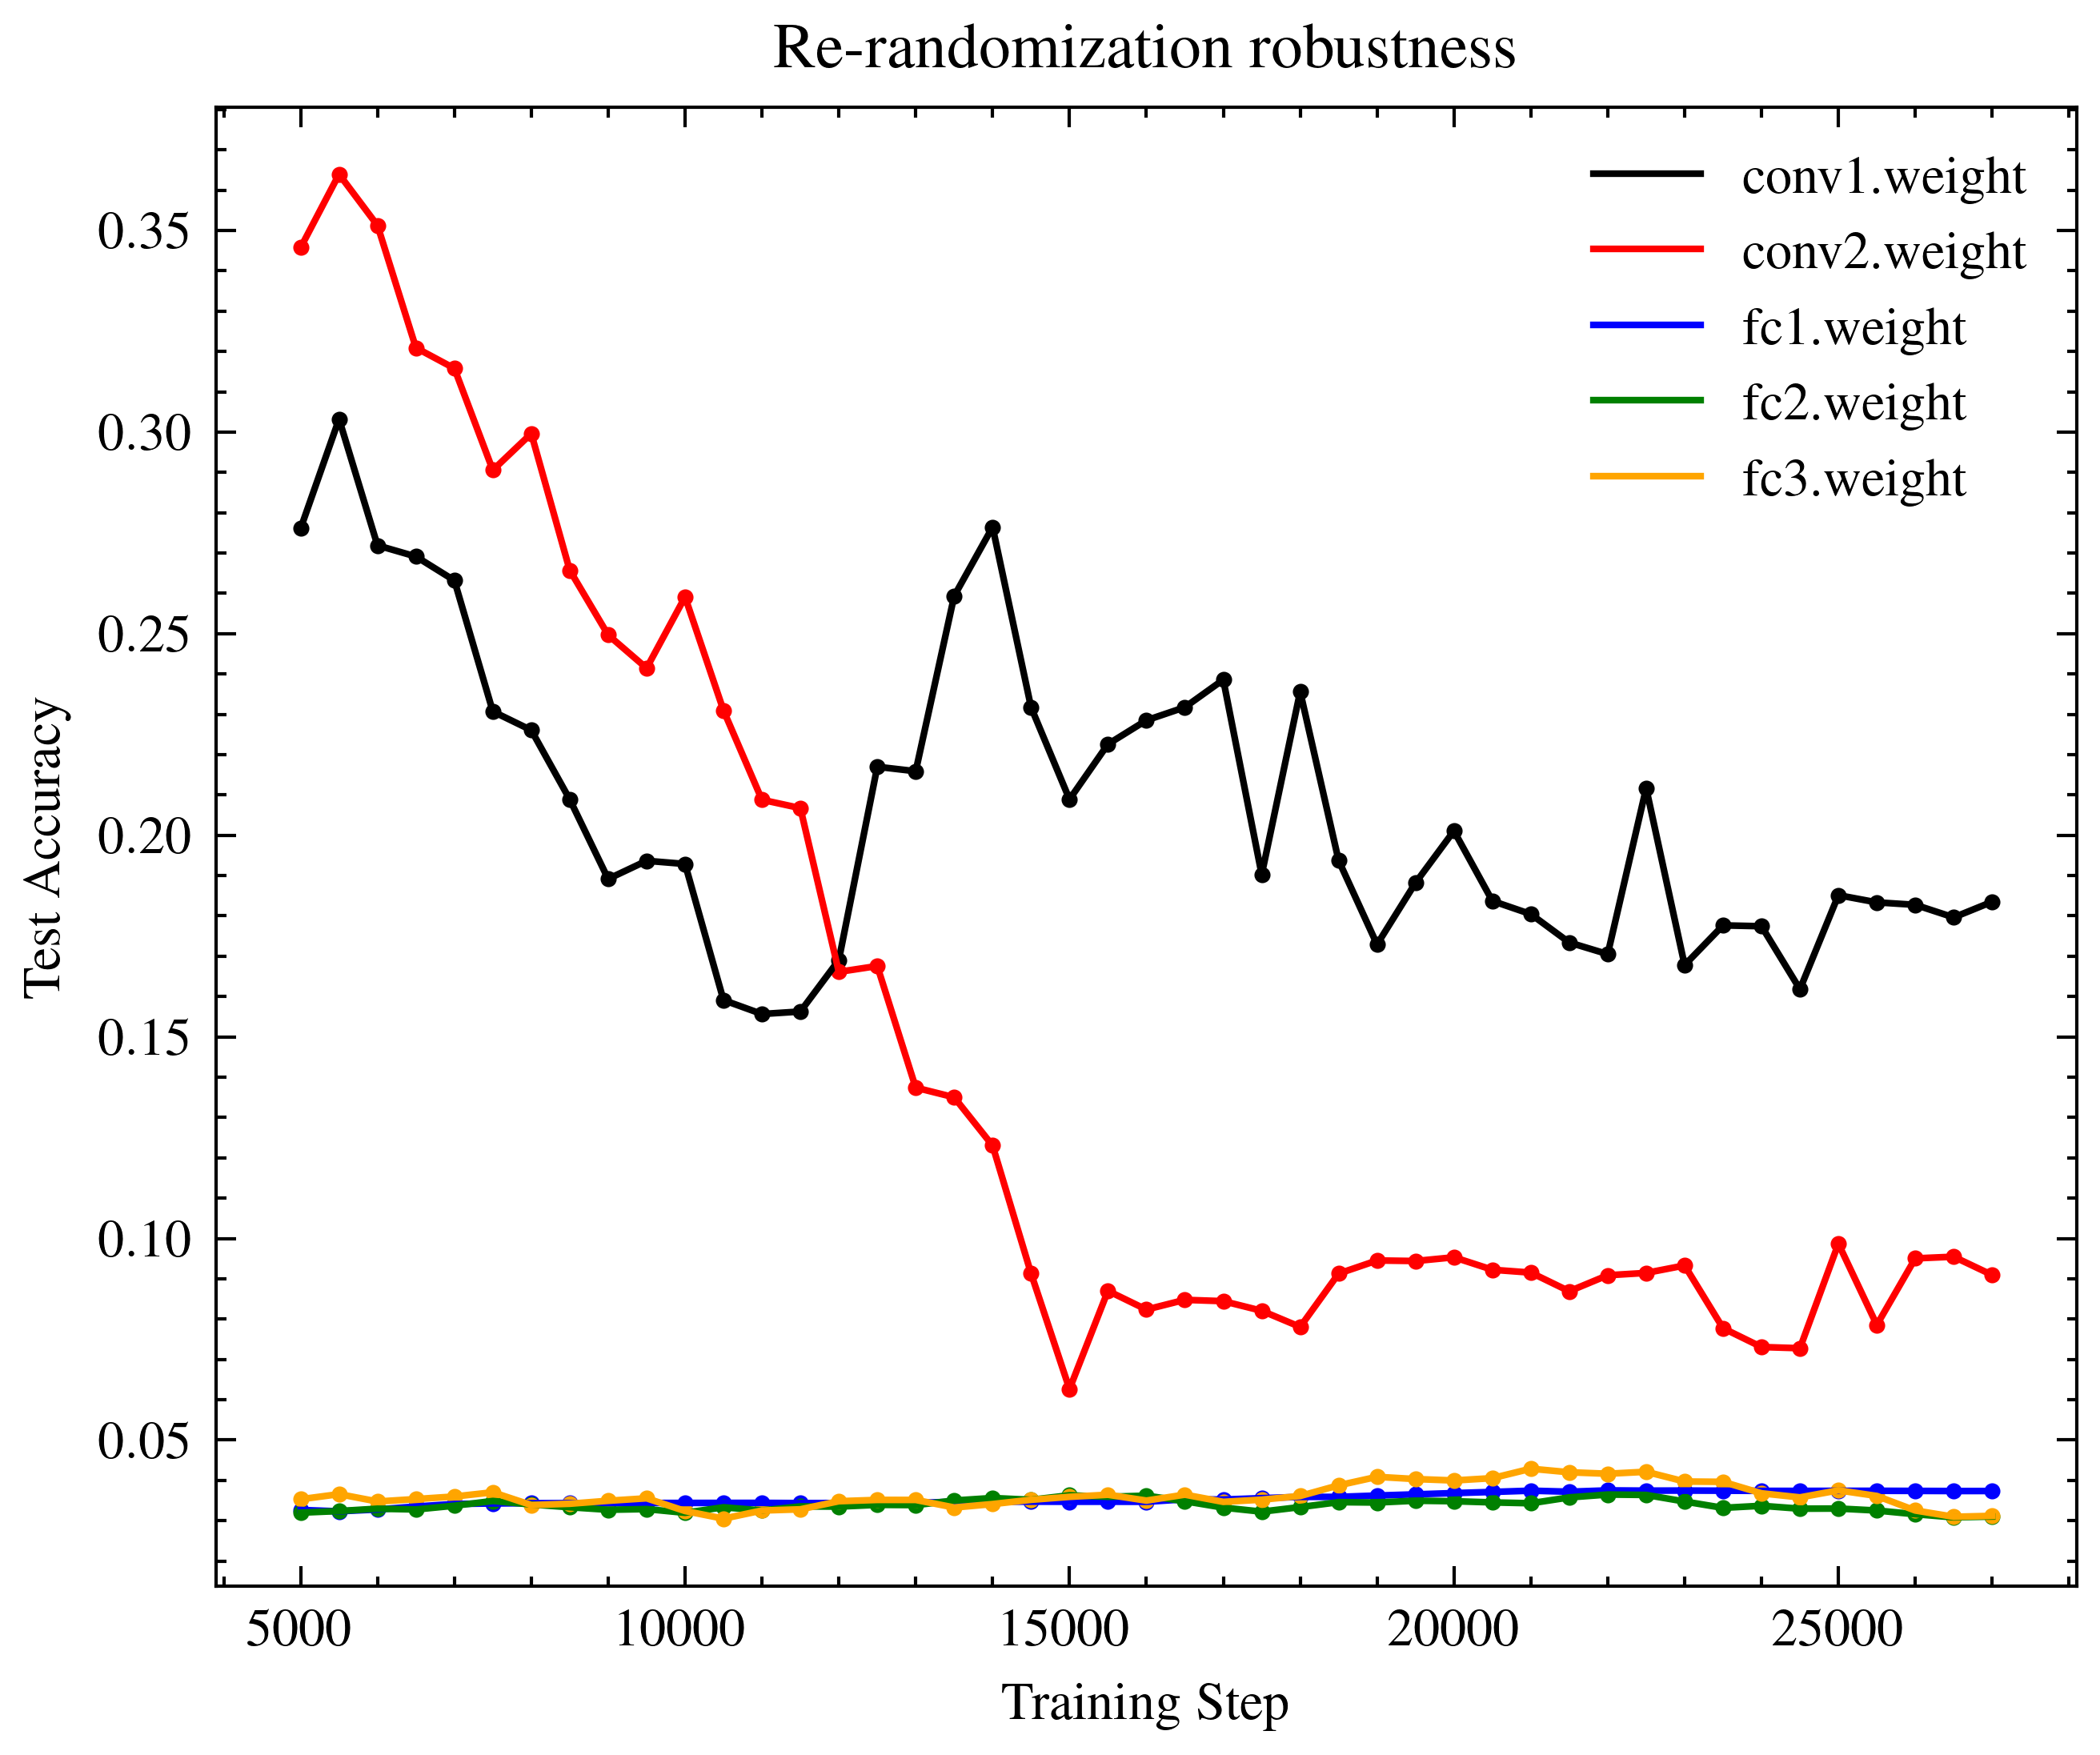

In [ ]:
plt.figure(figsize=(5, 4))

for layer in LAYERS:
	df_layer = df[df['layer'] == layer]
	df_layer['random_accuracy'] = df_layer['random_accuracy'].rolling(window=10).mean()
	plt.plot(df_layer['step'], df_layer['random_accuracy'], label=layer, color=layer_to_color[layer], linestyle='-')
	plt.scatter(df_layer['step'], df_layer['random_accuracy'], s=2, color=layer_to_color[layer])

plt.title('Re-randomization robustness')
plt.xlabel('Training Step')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('charts/re-randomization-robustness.png')
plt.show()

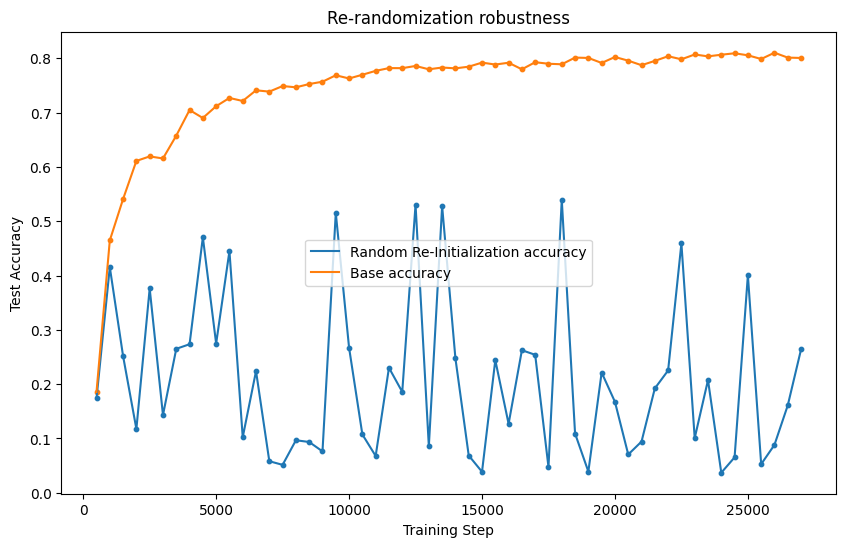

In [23]:
plt.figure(figsize=(10, 6))
df_layer = df[df['layer'] == 'conv1.weight']
plt.plot(df_layer['step'], df_layer['random_accuracy'], label='Random Re-Initialization accuracy')
plt.scatter(df_layer['step'], df_layer['random_accuracy'], s=10)

plt.plot(df_layer['step'], df_layer['base_accuracy'], label='Base accuracy')
plt.scatter(df_layer['step'], df_layer['base_accuracy'], s=10)

plt.title('Re-randomization robustness')
plt.xlabel('Training Step')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Parallel coordinates plots for parameter changes

In [3]:
def draw_parallel_coordinates_for_layer(layer):
    weights = []
    steps = []
    picked_weights = np.random.choice(55872000, 1000)

    for file in tqdm(glob.glob(f'{MODEL_PATH}/*.pth')):
        model_file_name = Path(file).name
        current_steps = int(model_file_name.split('_')[1].split('.')[0])
        steps.append(current_steps)
        state_dict = torch.load(file, weights_only=True)

        layer_weights = state_dict[layer].flatten().cpu()[picked_weights].numpy()
        weights.append((current_steps, layer_weights))

    weights = sorted(weights)
    _, weights = zip(*weights)

    weights = pd.DataFrame(weights).T.sample(1000)
    mean_values = weights.mean(axis=0)
    weights['class'] = 'Parameters'
    plt.figure(figsize=(5, 4))
    parallel_coordinates(weights, class_column='class', color='red', linestyle='-', linewidth=1, alpha=0.2)
    plt.plot(mean_values, color='blue', linestyle='-', linewidth=2, label='Mean Value')
    picked_xticks = np.arange(0, len(weights.columns) + 1, step=5)
    steps = np.array(sorted(steps))
    plt.xticks(ticks=picked_xticks, labels=steps[picked_xticks])
    plt.ylabel('Parameter Value')
    plt.xlabel('Training Step')
    plt.title(f'Change in {layer_to_view_name[layer]} Parameter Values Over Training Time')
    plt.savefig(f'charts/parameter_change_{layer}.png')
    plt.legend().remove()
    plt.grid(False)

In [ ]:
draw_parallel_coordinates_for_layer('conv1.weight')

100%|██████████| 56/56 [00:19<00:00,  2.81it/s]


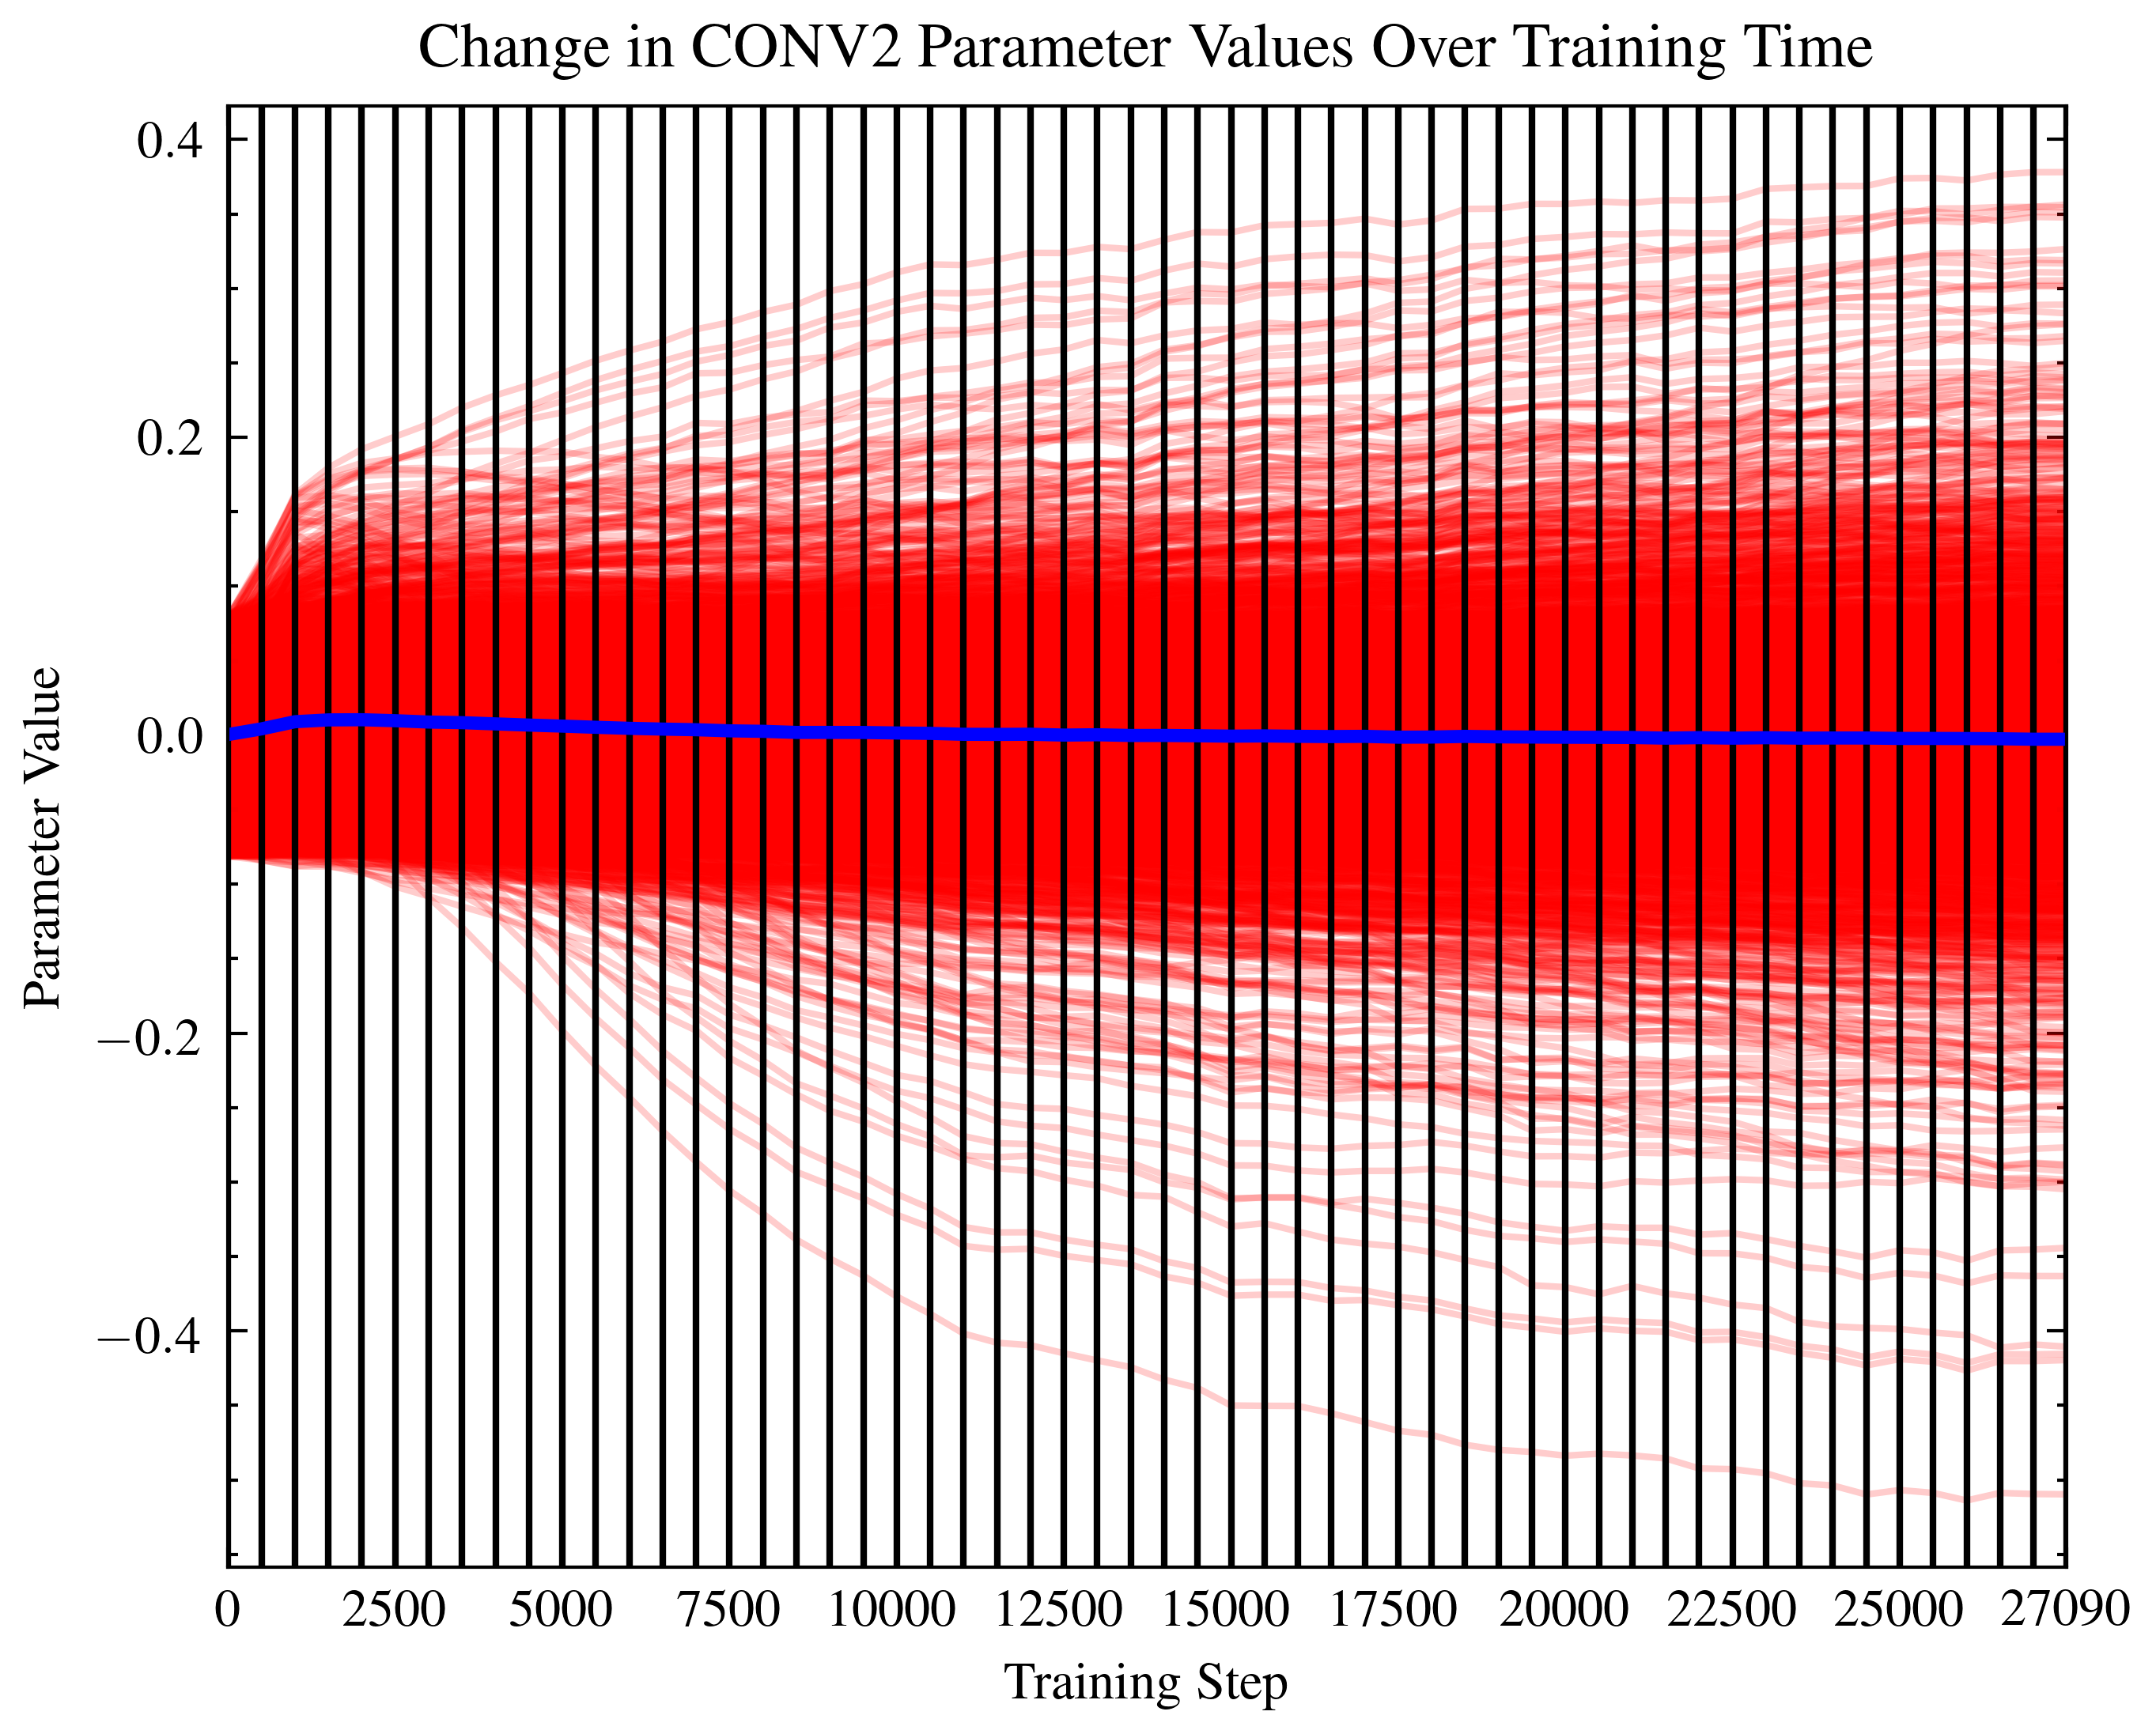

In [40]:
draw_parallel_coordinates_for_layer('conv2.weight')

100%|██████████| 56/56 [00:22<00:00,  2.52it/s]


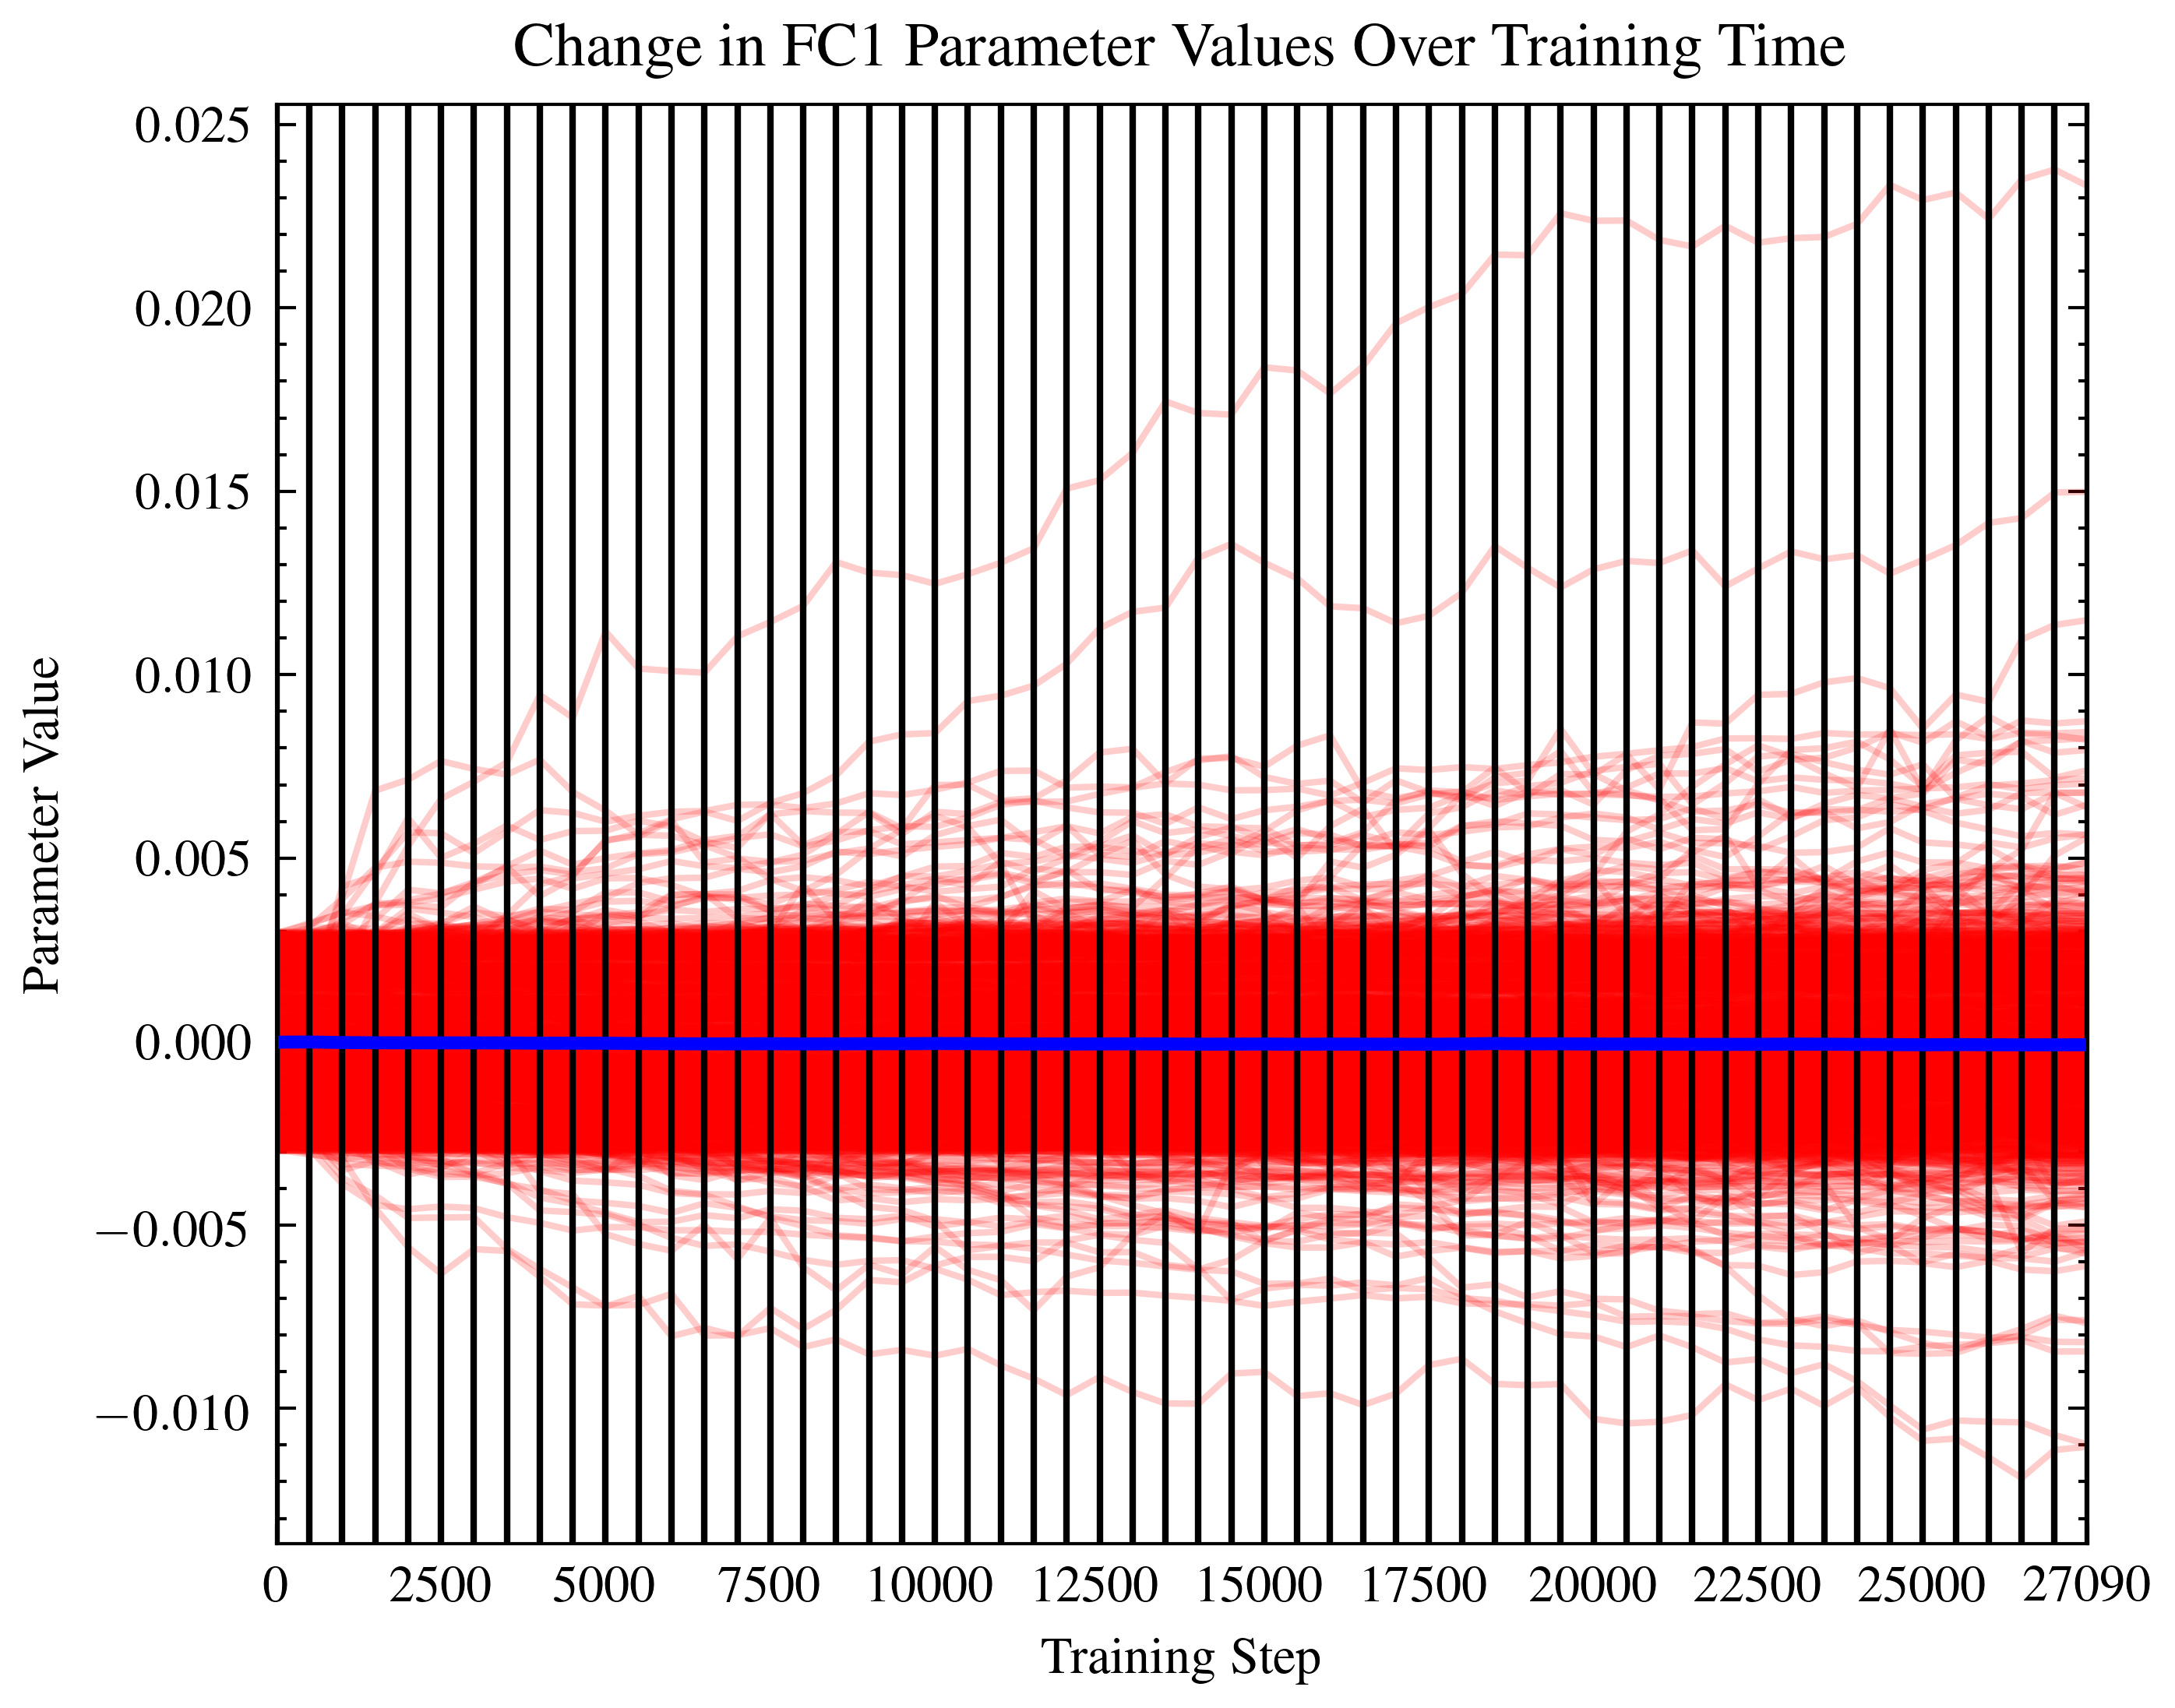

In [4]:
draw_parallel_coordinates_for_layer('fc1.weight')

100%|██████████| 56/56 [00:21<00:00,  2.60it/s]


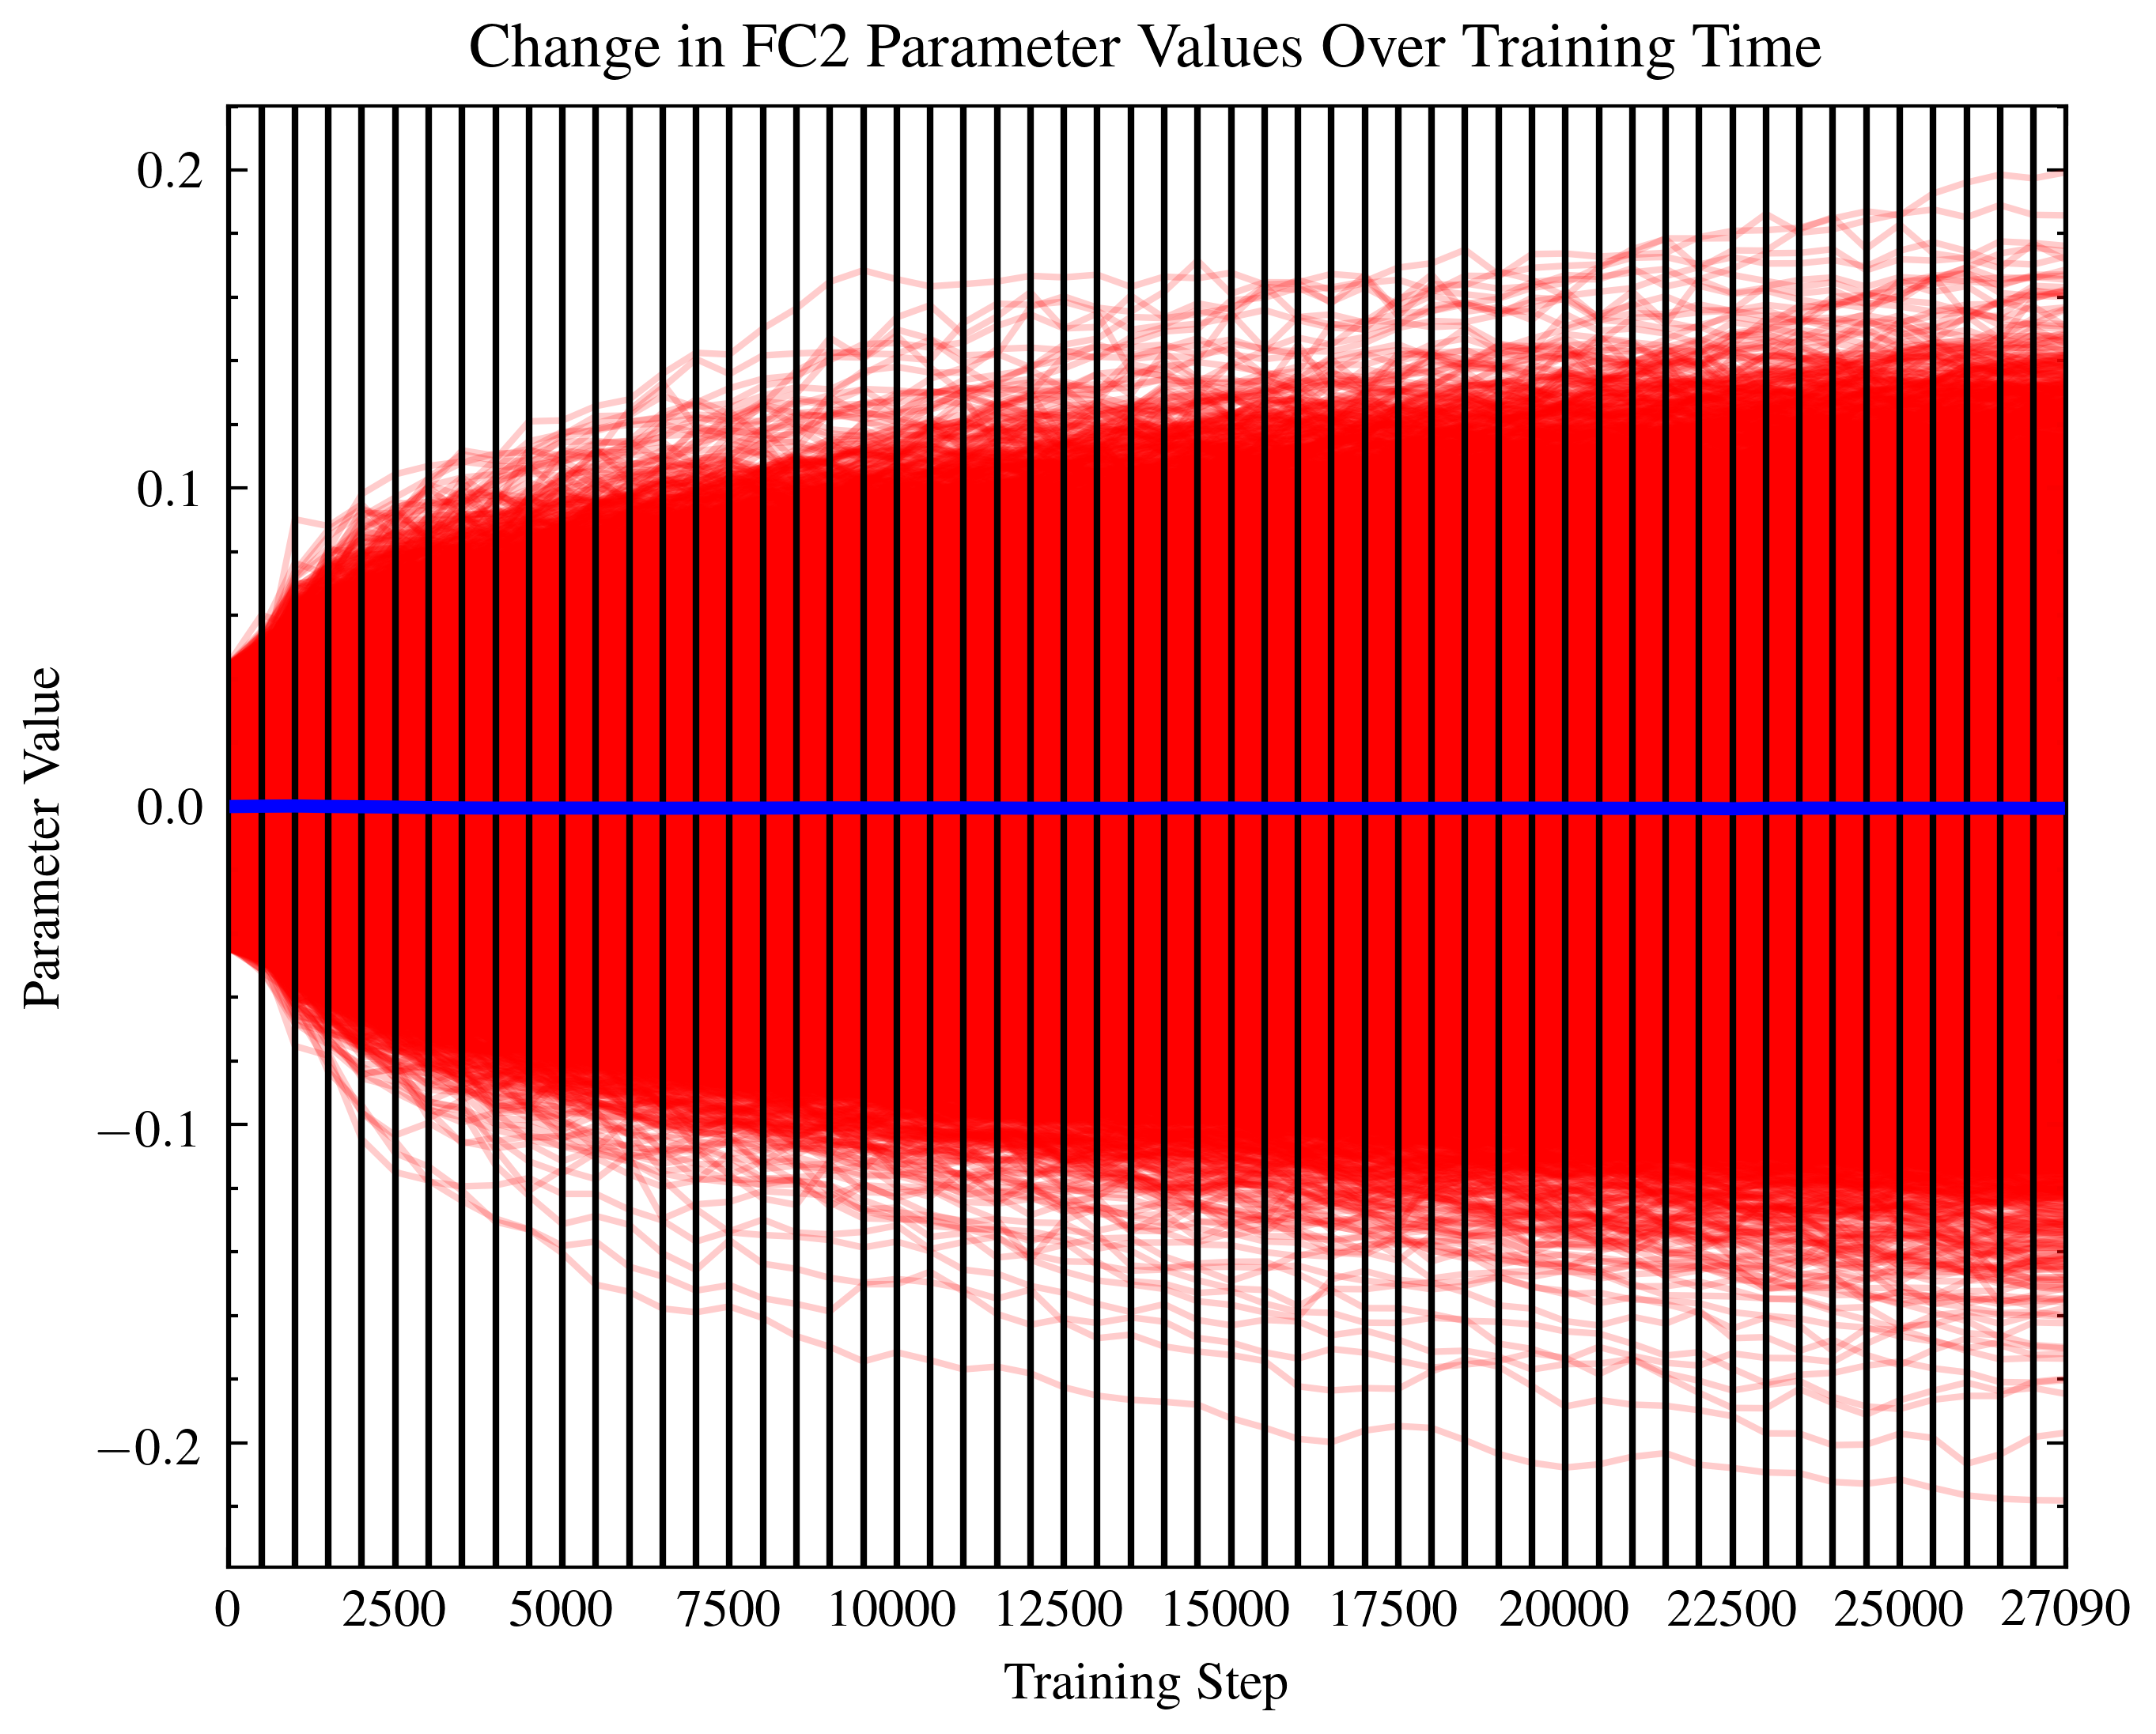

In [41]:
draw_parallel_coordinates_for_layer('fc2.weight')

100%|██████████| 56/56 [00:19<00:00,  2.81it/s]


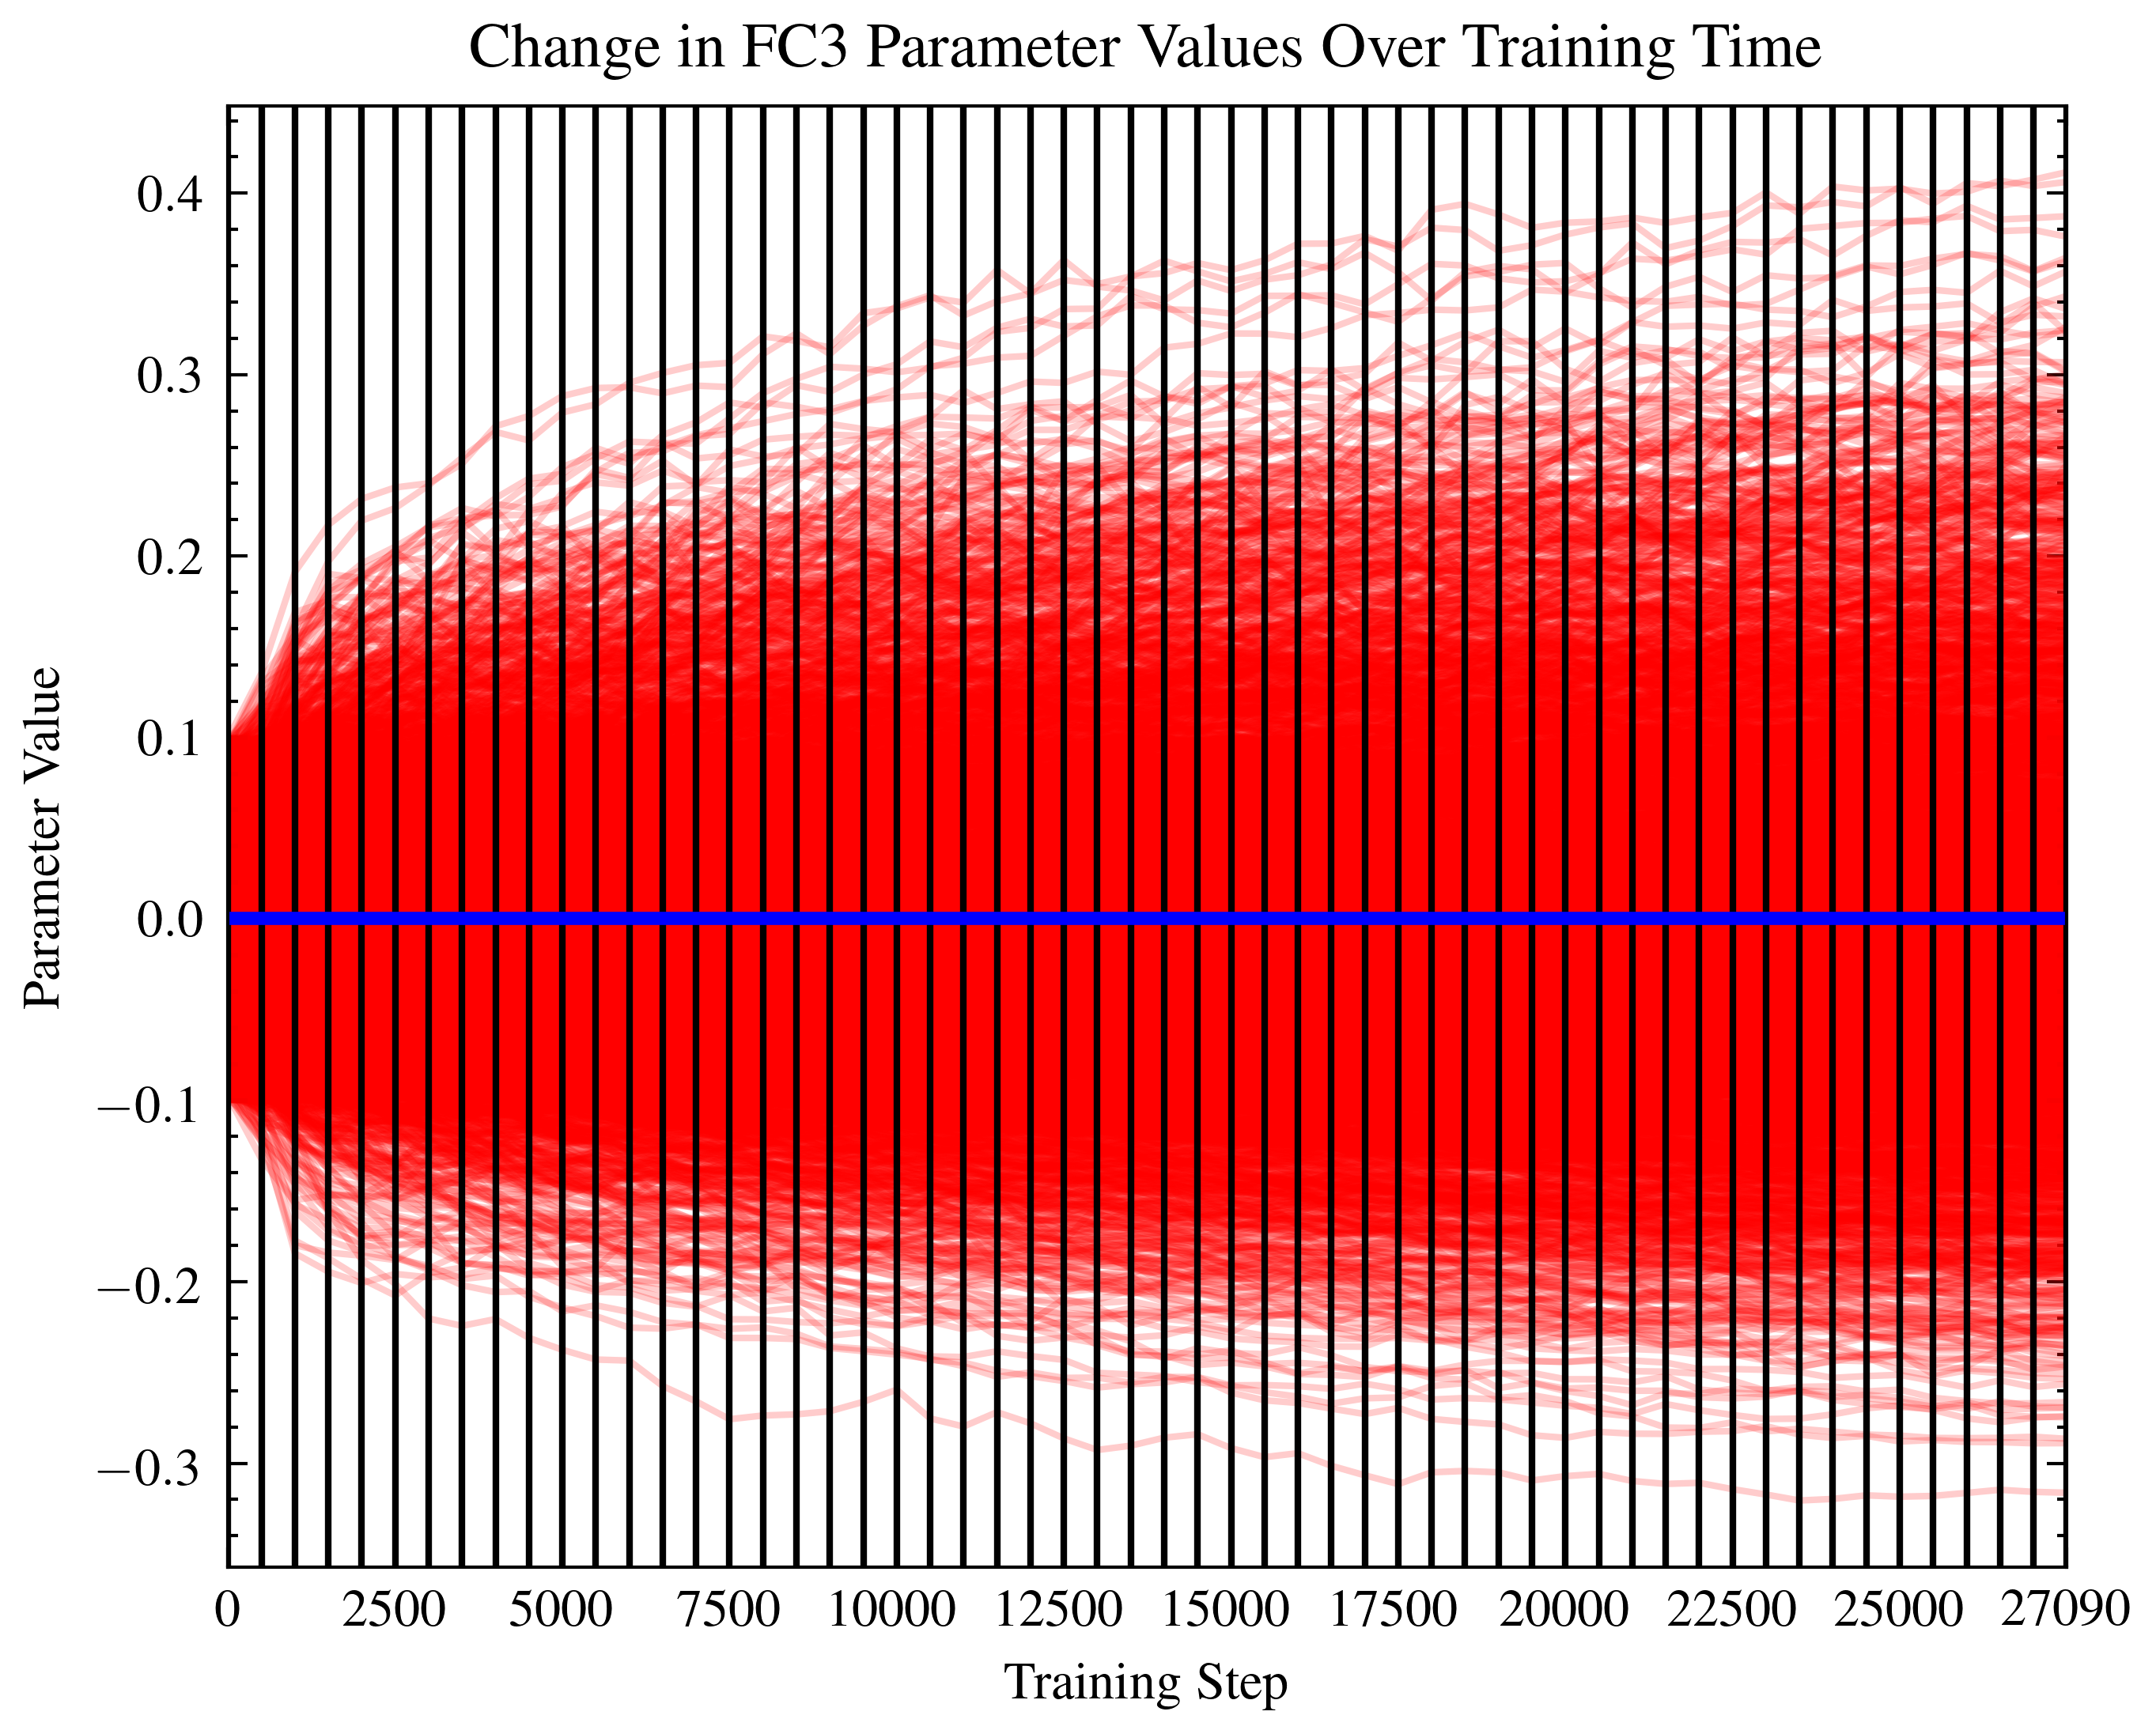

In [42]:
draw_parallel_coordinates_for_layer('fc3.weight')